## Driver code comparing output of different preproc software 
- Note: currently using output after atlas-based grouping
- Atlas used: DKT (Freesurfer) DKT-40 Mindboggle (ANTs: https://mindboggle.readthedocs.io/en/latest/labels.html) 

### Steps
- import data csvs 
- visualize data distributions 
- correlate features across pipelines
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
import time
from dask import compute, delayed
import dask.multiprocessing
from sklearn.utils import resample

from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import networkx as nx

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/'
data_dir = proj_dir + 'code/compare-surf-tools/data/'
results_dir = proj_dir + 'data/results/'
qc_dir =  data_dir + 'QC/'
fig_dir = data_dir + 'Paper_Figures/'

# subject demographics
demograph_file = data_dir + 'ABIDE_Phenotype.csv'

# software subdirs
ants_dir = data_dir + 'ANTs/'
civet_dir = data_dir + 'CIVET/'
fs51_dir = data_dir + 'FS5.1/'
fs53_dir = data_dir + 'FS5.3/'
fs60_dir = data_dir + 'FS6.0/'

# software CSVs
ants_file = ants_dir + 'ABIDE_ants_thickness_data.csv' 
civet_file = civet_dir + 'ABIDE_civet2.1_thickness.csv'
civet_dkt_roi_map_file = civet_dir + 'DKT/DKT_parcel_map_FS_CIVET.csv'

fs51_file = fs51_dir + 'cortical_fs5.1_measuresenigma_thickavg.csv' 
fs53_file =  fs53_dir + 'ABIDE_fs5.3_thickness.csv'
fs60_lh_file = fs60_dir + 'DKTatlas_thickness_lh.csv' #'DKTatlas_thickness_lh.csv' #'lh.aparc.thickness.table.test1' 
fs60_rh_file = fs60_dir + 'DKTatlas_thickness_rh.csv' #'DKTatlas_thickness_rh.csv' #'rh.aparc.thickness.table.test1'

#software_roi_map = '/DKT/Software_ROI_map.csv' # TODO: Need to use this instead parising names everytime.

# QC/outlier files
manual_outlier_file = qc_dir + 'manual/master_QC_table.csv'
auto_low_dim_outlier_file = qc_dir + 'auto/software/software_outlier_data.csv'
auto_high_dim_outlier_file = qc_dir + 'auto/high-dim/high_dim_outlier_data.csv'


### Workflow configs

In [3]:
software_list = ['ANTs','CIVET','FS5.1','FS5.3','FS6.0']
covar_list = ['SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']
qc_list = ['No_QC','manual_lenient','manual_stringent','auto_low_dim','auto_high_dim']

# pipeline parameter label along which the variation is assessed
data_label = 'software'

my_cmap = ["#b3de69","#0089c4","#fea7b4","#f2685a","#846fb6","#fdb462","#800013","#b3de69","#f768a1","#9f9afa","#d10a1e","#34495e","#799c11","#fff200",
           "#408080","#c8bfe7","#76cca8","#4c54b5","#a55ba6"]


### Global Vars

In [4]:
subject_ID_col = 'SubjID'

### Load data

In [5]:
# Demographics and Dx
demograph = pd.read_csv(demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

print('loading available datasets...\n')

data_dict = {}
for software in software_list:
    # CIVET 2.1
    if software == 'CIVET':
        civet_data = pd.read_csv(civet_file, dtype={subject_ID_col: str})
        print('shape of civet data {}'.format(civet_data.shape))
        # ROI names to match FS and CIVET parcels
        civet_dkt_roi_map = pd.read_csv(civet_dkt_roi_map_file)
        data_std = standardize_civet_data(civet_data, subject_ID_col, civet_dkt_roi_map)

    # ANTs
    if software == 'ANTs':
        ants_data = pd.read_csv(ants_file, header=2)
        print('shape of ants data {}'.format(ants_data.shape))
        data_std = standardize_ants_data(ants_data, subject_ID_col)

    # FS    
    if software == 'FS5.1':
        fs51_data = pd.read_csv(fs51_file)
        print('shape of fs51 data {}'.format(fs51_data.shape))
        data_std = standardize_fs_data(fs51_data, subject_ID_col)
        
    if software == 'FS5.3':
        fs53_data = pd.read_csv(fs53_file)
        print('shape of fs53 data {}'.format(fs53_data.shape))
        data_std = standardize_fs_data(fs53_data, subject_ID_col)

    if software == 'FS6.0':
        fs60_lh_data = pd.read_csv(fs60_lh_file, delim_whitespace=True)
        fs60_rh_data = pd.read_csv(fs60_rh_file, delim_whitespace=True)
        print('shape of fs60 data l: {}, r: {}'.format(fs60_lh_data.shape,fs60_rh_data.shape))        
        data_std = standardize_fs60_data(fs60_lh_data, fs60_rh_data, subject_ID_col,aparc='aparc.DKTatlas')
    
    print('  shape of stdized {} data {}\n'.format(software, data_std.shape))
    data_dict[software] = data_std

loading available datasets...

shape of ants data (1101, 99)
  shape of stdized ANTs data (1101, 90)

shape of civet data (899, 65)
  shape of stdized CIVET data (899, 65)

shape of fs51 data (1112, 74)
  shape of stdized FS5.1 data (1112, 74)

shape of fs53 data (976, 74)
  shape of stdized FS5.3 data (976, 74)

shape of fs60 data l: (1047, 33), r: (1047, 34)
shape of left and right merge fs6.0 df (1047, 66)
  shape of stdized FS6.0 data (1047, 66)



### Create master dataframe

In [6]:
na_action = 'drop' # options: ignore, drop; anything else will not use the dataframe for analysis. 

master_df_raw, common_subs, common_roi_cols = combine_processed_data(data_dict, subject_ID_col, na_action, data_label)

# Add demographic columns to the master_df_raw
useful_demograph = demograph[[subject_ID_col] + covar_list].copy()

# DX_GROUP: (orginal: 1:ASD, 2:Controls) 
# Replace to (2 with 0 for statsmodels to define 1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

master_df_raw = pd.merge(master_df_raw, useful_demograph, how='left', on=subject_ID_col)

print('\nmaster df shape after adding demographic info {}'.format(master_df_raw.shape))
print('\nNumber of common subjects {}, ROIs {}'.format(len(common_subs),                                                        
                                                       len(common_roi_cols)))


Number of datasets: 5
Finding common subject and columns
dataset : ANTs
common subs: 1101
dataset : CIVET
common subs: 898
dataset : FS5.1
common subs: 898
dataset : FS5.3
common subs: 800
dataset : FS6.0
common subs: 778
Number of common subjects and columns: 778, 63

checking ANTs dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (778, 64)

checking CIVET dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (1556, 64)

checking FS5.1 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (2334, 64)

checking FS5.3 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (3112, 64)

checking FS6.0 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shap

### QC filters
- Manual (Gleb or Maarten)
- Automatic (Amadou) 
- Ringing subs: ['0050197',0050211','0050049','0051160','0050815','0050418','0050422','0050423','0050309','0050283','0050313','0050323','0051353','0051352','0051334']

In [7]:
# Dictionary allow iterating and QC comparisons later
# Default master_df is without QC

master_df_dict = {}
n_workflow = len(master_df_raw[data_label].unique())
outlier_df = pd.DataFrame(index=master_df_raw[subject_ID_col].unique())
for qc in qc_list:
    if qc == 'No_QC':
        print('No QC applied')
        filtered_df = master_df_raw
        filtered_subs = filtered_df[subject_ID_col].unique()
        print('Resultant number of subjects {}'.format(len(filtered_subs)))
    else:            
        if qc == 'manual_lenient':
            qc_df = pd.read_csv(manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_maarten',[0]) # keep subs
        elif qc == 'manual_stringent':
            qc_df = pd.read_csv(manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
        elif qc == 'auto_low_dim':
            qc_df_long = pd.read_csv(auto_low_dim_outlier_file ,dtype={'SubjID': int})
            qc_df = qc_df_long.pivot(index=subject_ID_col,columns='pipeline',values='outlier_ind')
            qc_df.apply(pd.to_numeric)
            #keep only if a subject is not an outlier in any of the software
            qc_df['QC_outlier'] = qc_df[list(qc_df.columns)].sum(axis=1) 
            qc_df[subject_ID_col] = qc_df.index
            qc_criterion = ('QC_outlier',[0])                
        elif qc == 'auto_high_dim':
            qc_df = pd.read_csv(auto_high_dim_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('OD_high_dim',['0']) # keep subs
        else:
            print('Unknow QC type')
            

        # Subjects you want to keep based on other crieria for sample size purposes
        external_criterion = {'SITE_ID':3*n_workflow}
        filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
        filtered_subs = filtered_df[subject_ID_col].unique()
        outlier_df[qc] = np.where(outlier_df.index.isin(filtered_subs),0,1)
        
    master_df_dict[qc] = filtered_df

master_df = master_df_dict['No_QC'] # Default

No QC applied
Resultant number of subjects 778

Filtering based on QC_maarten. Number subjects before filtering 778
Resultant number of subjects 748
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID Series([], Name: SITE_ID, dtype: int64)
Resultant number of subjects 748

Filtering based on QC_gleb. Number subjects before filtering 778
Resultant number of subjects 204
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID OLIN       15
UCLA_2     15
MAX_MUN    15
PITT        5
Name: SITE_ID, dtype: int64
Resultant number of subjects 194

Filtering based on QC_outlier. Number subjects before filtering 778
Resultant number of subjects 685
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workf

### Basic demographic distributions


QC type: No_QC
Number of subjects 778

QC type: manual_lenient
Number of subjects 748

QC type: manual_stringent
Number of subjects 194

QC type: auto_low_dim
Number of subjects 683

QC type: auto_high_dim
Number of subjects 662


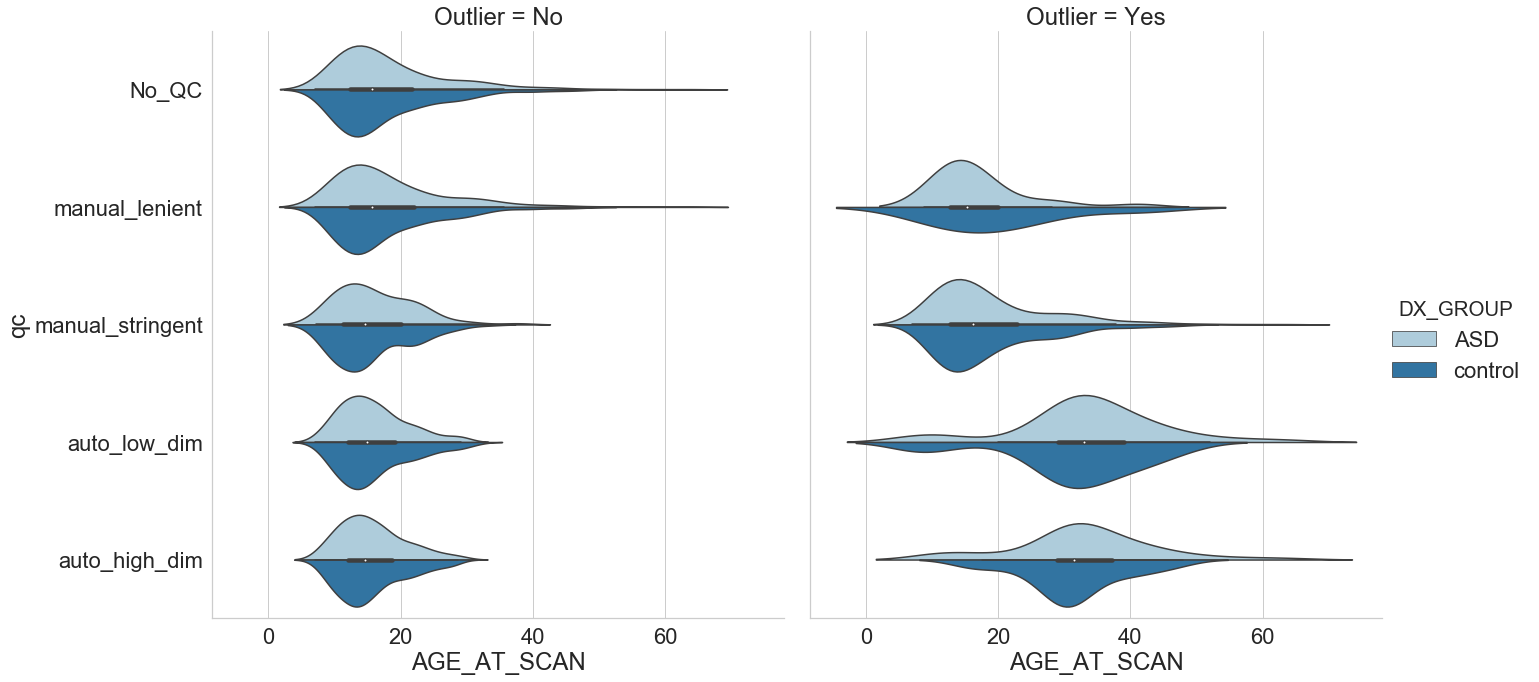

In [8]:
demo_df_concat = pd.DataFrame()

for qc in qc_list:
    demo_dist_df = master_df_raw[master_df_raw[data_label]=='CIVET'][[subject_ID_col]+covar_list].copy()
    demo_dist_df['Outlier'] = np.tile('Yes',len(demo_dist_df))
    
    print('\nQC type: {}'.format(qc))
    master_df_long = master_df_dict[qc]
    master_df = master_df_long[master_df_long[data_label]=='CIVET']
    print('Number of subjects {}'.format(len(master_df)))
    filtered_subs = master_df[subject_ID_col].unique()
    
    demo_dist_df.loc[demo_dist_df[subject_ID_col].isin(filtered_subs),'Outlier'] = 'No'
    demo_dist_df['qc'] = np.tile(qc,len(demo_dist_df))
    demo_df_concat = demo_df_concat.append(demo_dist_df[covar_list+['qc','Outlier']])
    
plot_df = demo_df_concat.copy()
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
plot_df['SEX'] = plot_df['SEX'].replace({0:'M', 1:'F'})

sns.set(font_scale=2)
palette="Paired"
with sns.axes_style("whitegrid"):
    sns.catplot(x="AGE_AT_SCAN", y="qc", hue="DX_GROUP", kind="violin", split=True, height=10, aspect=1,
                col='Outlier', palette=palette, data=plot_df,sharey=True);

In [9]:
demo_df_concat[demo_df_concat['Outlier']=='No'].groupby(['qc','Outlier','DX_GROUP']).std()

SEX  AGE_AT_SCAN
qc               Outlier DX_GROUP                       
No_QC            No      0         0.372768     7.727741
                         1         0.323595     8.787064
auto_high_dim    No      0         0.382177     5.013505
                         1         0.326563     4.943179
auto_low_dim     No      0         0.373583     5.476263
                         1         0.319999     5.087132
manual_lenient   No      0         0.375684     7.680928
                         1         0.325714     8.880277
manual_stringent No      0         0.383361     5.574189
                         1         0.331010     5.895294

Total number of subjects: 778

outlier overlap
                  manual_lenient  manual_stringent  auto_low_dim  \
manual_lenient                30                30             6   
manual_stringent              30               584            89   
auto_low_dim                   6                89            95   
auto_high_dim                  7               110            81   

                  auto_high_dim  
manual_lenient                7  
manual_stringent            110  
auto_low_dim                 81  
auto_high_dim               116  


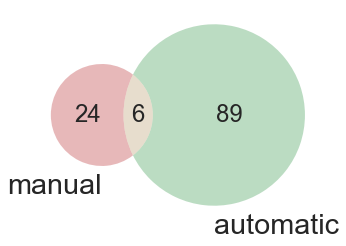

In [10]:
# Outlier comparisons
outlier_overlap = outlier_df.T.dot(outlier_df)
print('Total number of subjects: {}\n'.format(len(outlier_df)))
print('outlier overlap')
print(outlier_overlap)

# Venn diagrams
s1 = set(outlier_df[outlier_df['manual_lenient']==1].index)
s2 = set(outlier_df[outlier_df['manual_stringent']==1].index)
s3 = set(outlier_df[outlier_df['auto_low_dim']==1].index)
v = venn2([s1,s3],set_labels = ('manual', 'automatic'))
#v = venn3([s1,s2,s3],set_labels = ('manual_maarten', 'manual_gleb', 'auto'))


### Correlation between software tools

In [31]:
master_df = master_df_dict['No_QC']

possible_pairs = list(itertools.combinations(data_dict.keys(), 2))
xcorr_pairs_df = pd.DataFrame()
table_df_dict = {'dx_0': pd.DataFrame(columns=software_list,index=software_list),
                 'dx_1': pd.DataFrame(columns=software_list,index=software_list)}
for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    for dx in [0,1]:
        df1 = master_df[(master_df[data_label]==pipe1)&(master_df['DX_GROUP']==dx)][[subject_ID_col]+common_roi_cols]
        df2 = master_df[(master_df[data_label]==pipe2)&(master_df['DX_GROUP']==dx)][[subject_ID_col]+common_roi_cols]
        xcorr_df = cross_correlations(df1,df2,subject_ID_col)
        xcorr_df['{}_pair'.format(data_label)] = np.tile(str('{}-{}'.format(pair[0],pair[1])),len(xcorr_df))
        xcorr_df['DX_GROUP'] = np.tile(dx,len(xcorr_df))
        xcorr_pairs_df = xcorr_pairs_df.append(xcorr_df)
        mean_corr = np.mean(xcorr_df['correlation'].values)
        #print('DX {}, Avg cross correlation between {} & {} = {:4.2f}\n'.format(dx, pipe1,pipe2,mean_corr))
        table_df = table_df_dict['dx_{}'.format(dx)]
        table_df.loc[pipe1,pipe2] = mean_corr.round(2)
        table_df.loc[pipe2,pipe1] = mean_corr.round(2)

print('Correlation between software tools')
table_df_dict

Correlation between software tools


{'dx_0':        ANTs CIVET FS5.1 FS5.3 FS6.0
 ANTs    NaN  0.43  0.45  0.48  0.44
 CIVET  0.43   NaN  0.48  0.53  0.52
 FS5.1  0.45  0.48   NaN  0.89  0.85
 FS5.3  0.48  0.53  0.89   NaN   0.9
 FS6.0  0.44  0.52  0.85   0.9   NaN,
 'dx_1':        ANTs CIVET FS5.1 FS5.3 FS6.0
 ANTs    NaN  0.41  0.41  0.47  0.43
 CIVET  0.41   NaN  0.47  0.52  0.52
 FS5.1  0.41  0.47   NaN  0.88  0.84
 FS5.3  0.47  0.52  0.88   NaN  0.89
 FS6.0  0.43  0.52  0.84  0.89   NaN}

Shape of cross-corr df (1240, 4), number of pairs 10


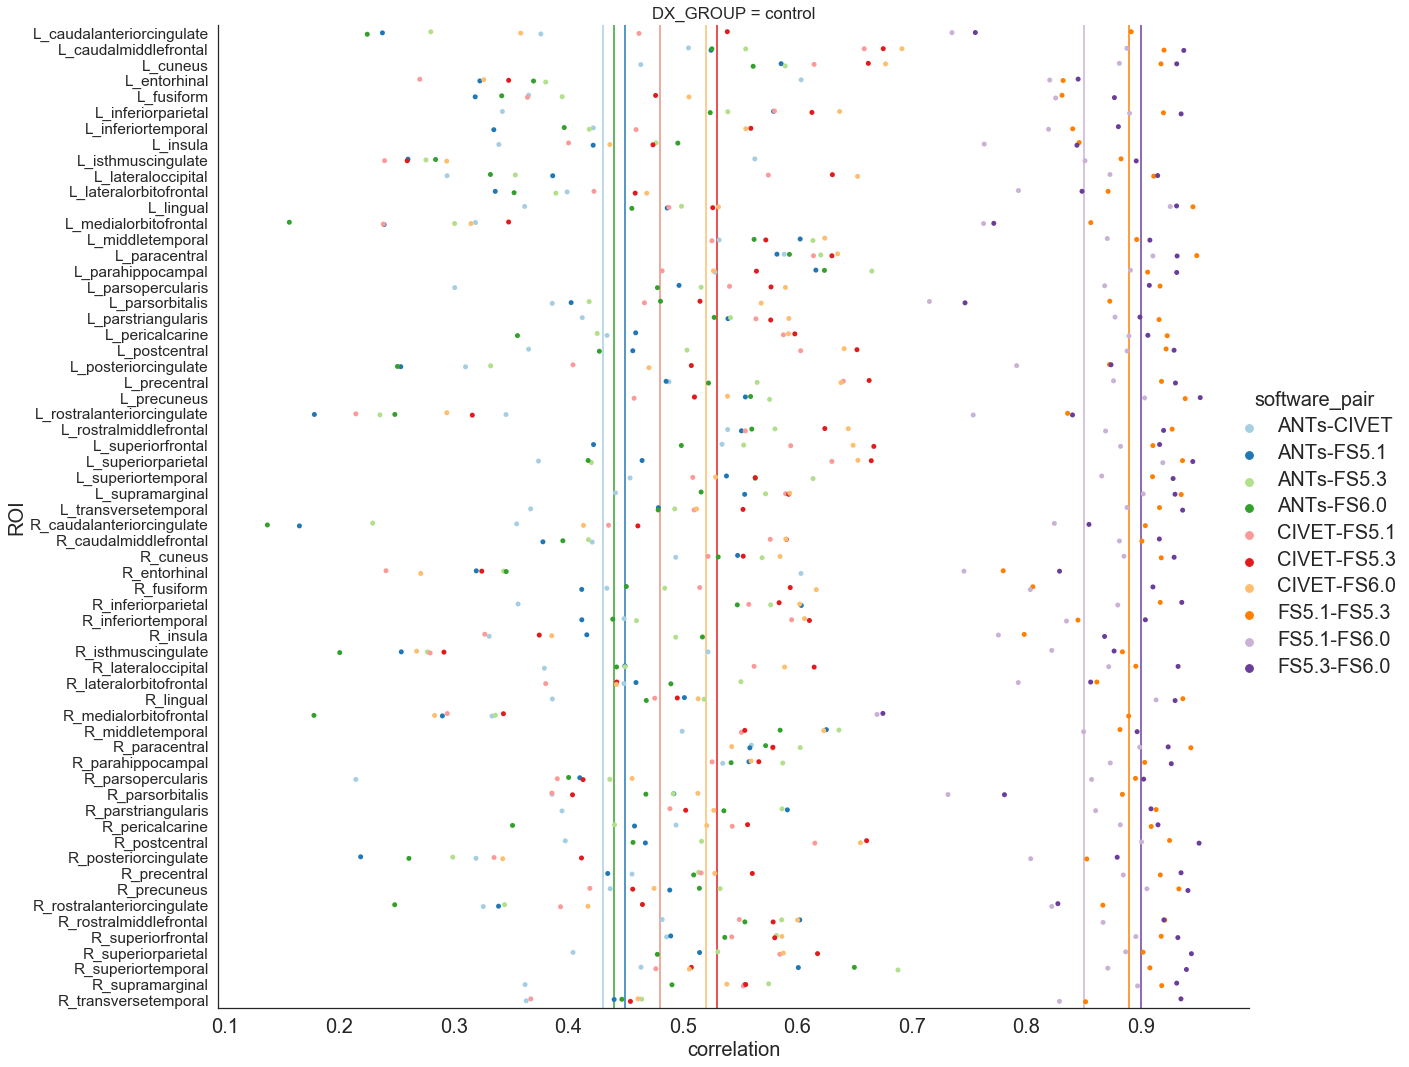

In [32]:
# Plot ROI wise correlations

plot_df = xcorr_pairs_df
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
n_pairs = len(xcorr_pairs_df['{}_pair'.format(data_label)].unique())
print('Shape of cross-corr df {}, number of pairs {}'.format(xcorr_pairs_df.shape, n_pairs))
roi_order = sorted(list(xcorr_pairs_df['ROI'].unique()))
sns.set(font_scale=1.4)
palette = sns.color_palette('Paired')
#colors = ["windows blue", "tomato", "greyish", "faded green", "dusty purple","dark grey"]
#palette = sns.color_palette("cubehelix", n_pairs,)
# palette =  ["#846fb6", "#41ae76","#b3de69",  "#fdb462", "#80b1d3", "#880014", 
#             "#f768a1", "#0089c4", "#3498db", "#e74c3c",  "#34495e", "#799c11"]

# palette = ["#80b1d3","#41ae76","#846fb6","#fdb462","#fed976","#b3de69", "#0089c4","#f768a1",
#            "#9f9afa","#800013","#d10a1e","#34495e","#799c11","#fff200"]
with sns.axes_style("white"):
    g = sns.catplot(x='correlation',y='ROI',hue='{}_pair'.format(data_label),col='DX_GROUP',
                    palette=palette, aspect=1.2,height=15,kind='strip',order=roi_order,
                    data=plot_df[plot_df['DX_GROUP']=='control'])
    g.set_xticklabels(fontsize=20)
    g.set_xlabels(fontsize=20)
    g.set_ylabels(fontsize=20)
    g.set_titles(fontsize=40)
    plt.setp(g._legend.get_texts(), fontsize='20') # for legend text
    plt.setp(g._legend.get_title(), fontsize='20') # for legend title
    
    triu_idx = np.triu_indices(5,1)
    vline_vals = table_df_dict['dx_0'].values[triu_idx]### need to change this if DX group is changed
    for v, val in enumerate(vline_vals):
        plt.axvline(val,color=palette[v])

#### Rank ROIs based on high and low correlation

In [259]:
a = xcorr_pairs_df.groupby(['ROI']).median().reset_index().sort_values(by='correlation')
print(a['correlation'].median())
a

0.553179746290386


,ROI,correlation
24,L_rostralanteriorcingulate,0.271368
8,L_isthmuscingulate,0.289084
39,R_isthmuscingulate,0.306051
12,L_medialorbitofrontal,0.317997
52,R_posteriorcingulate,0.339073
3,L_entorhinal,0.365741
0,L_caudalanteriorcingulate,0.369015
34,R_entorhinal,0.376777
55,R_rostralanteriorcingulate,0.384137
4,L_fusiform,0.393252


#### Plot distributions for exemplar ROIs

In [257]:
# lowest median corr: L_rostralanteriorcingulate
# median median corr: L_superiorfrontal
# highest median corr: R_postcentral
# other intesting ROIs: insula, entorhinal, parahippocampal

roi = 'L_cuneus'
roi_paired_df_concat = pd.DataFrame()

#for dx in [0,1]:
#roi_df = master_df[(master_df['DX_GROUP']==dx)][[subject_ID_col,roi,data_label]]
roi_df = master_df[[subject_ID_col,roi,data_label]]
roi_df_pivot = roi_df.pivot(index=subject_ID_col,columns=data_label,values=roi)

for pair in possible_pairs:
    roi_paired_df = roi_df_pivot[[pair[0],pair[1]]]
    corr,p = pearsonr(roi_paired_df[pair[0]],roi_paired_df[pair[1]])
    if p < 0.05:
        p_txt = '*'
    else:
        p_txt = ''

    roi_paired_df = roi_paired_df.rename(columns={pair[0]:'software_1',pair[1]:'software_2'})        
    roi_paired_df['software_pair'] = '{}-{} \n( r={:3.2f}{} )'.format(pair[0], pair[1], corr, p_txt)
    #roi_paired_df['DX_GROUP'] =dx
    roi_paired_df_concat = roi_paired_df_concat.append(roi_paired_df)


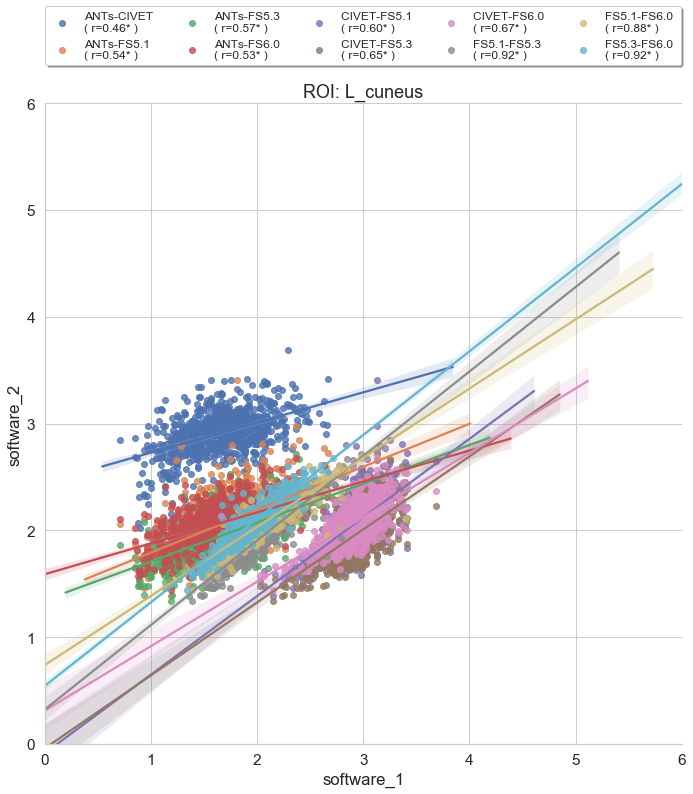

In [258]:
#dx = 'control'
plot_df = roi_paired_df_concat.copy()
#plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
#plot_df = plot_df[plot_df['DX_GROUP']==dx]

with sns.axes_style("whitegrid"):
    g = sns.lmplot(x='software_1',y='software_2',hue='software_pair',data=plot_df,height=10,
                  sharey=False,legend=False)
    g.axes[0,0].set_xlim(0,6)
    g.axes[0,0].set_ylim(0,6)
    ax = plt.gca()
    ax.set_title('ROI: {}'.format(roi), fontsize=18)
#     g.axes[0,1].set_xlim(0,4)
#     g.axes[0,1].set_ylim(0,4)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize=12)


In [254]:
# fig_name = 'ROI_correlation_{}_scatter_plot.png'.format(roi)
# save_path = '{}{}'.format(fig_dir,fig_name)
# g.savefig(save_path, dpi=300)
# print('Figure saved at {}'.format(save_path))

Figure saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/Paper_Figures/ROI_correlation_L_parahippocampal_scatter_plot.png


### Covariance / Correlation between ROIs

Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (662, 63), df_corr (62, 62)
Shapes df (662, 63), df_corr (62, 62)
Shapes df (662, 63), df_corr (62, 62)
Shapes df (662, 63), df_corr (62, 62)
Shapes df (662, 63), df_corr (62, 62)


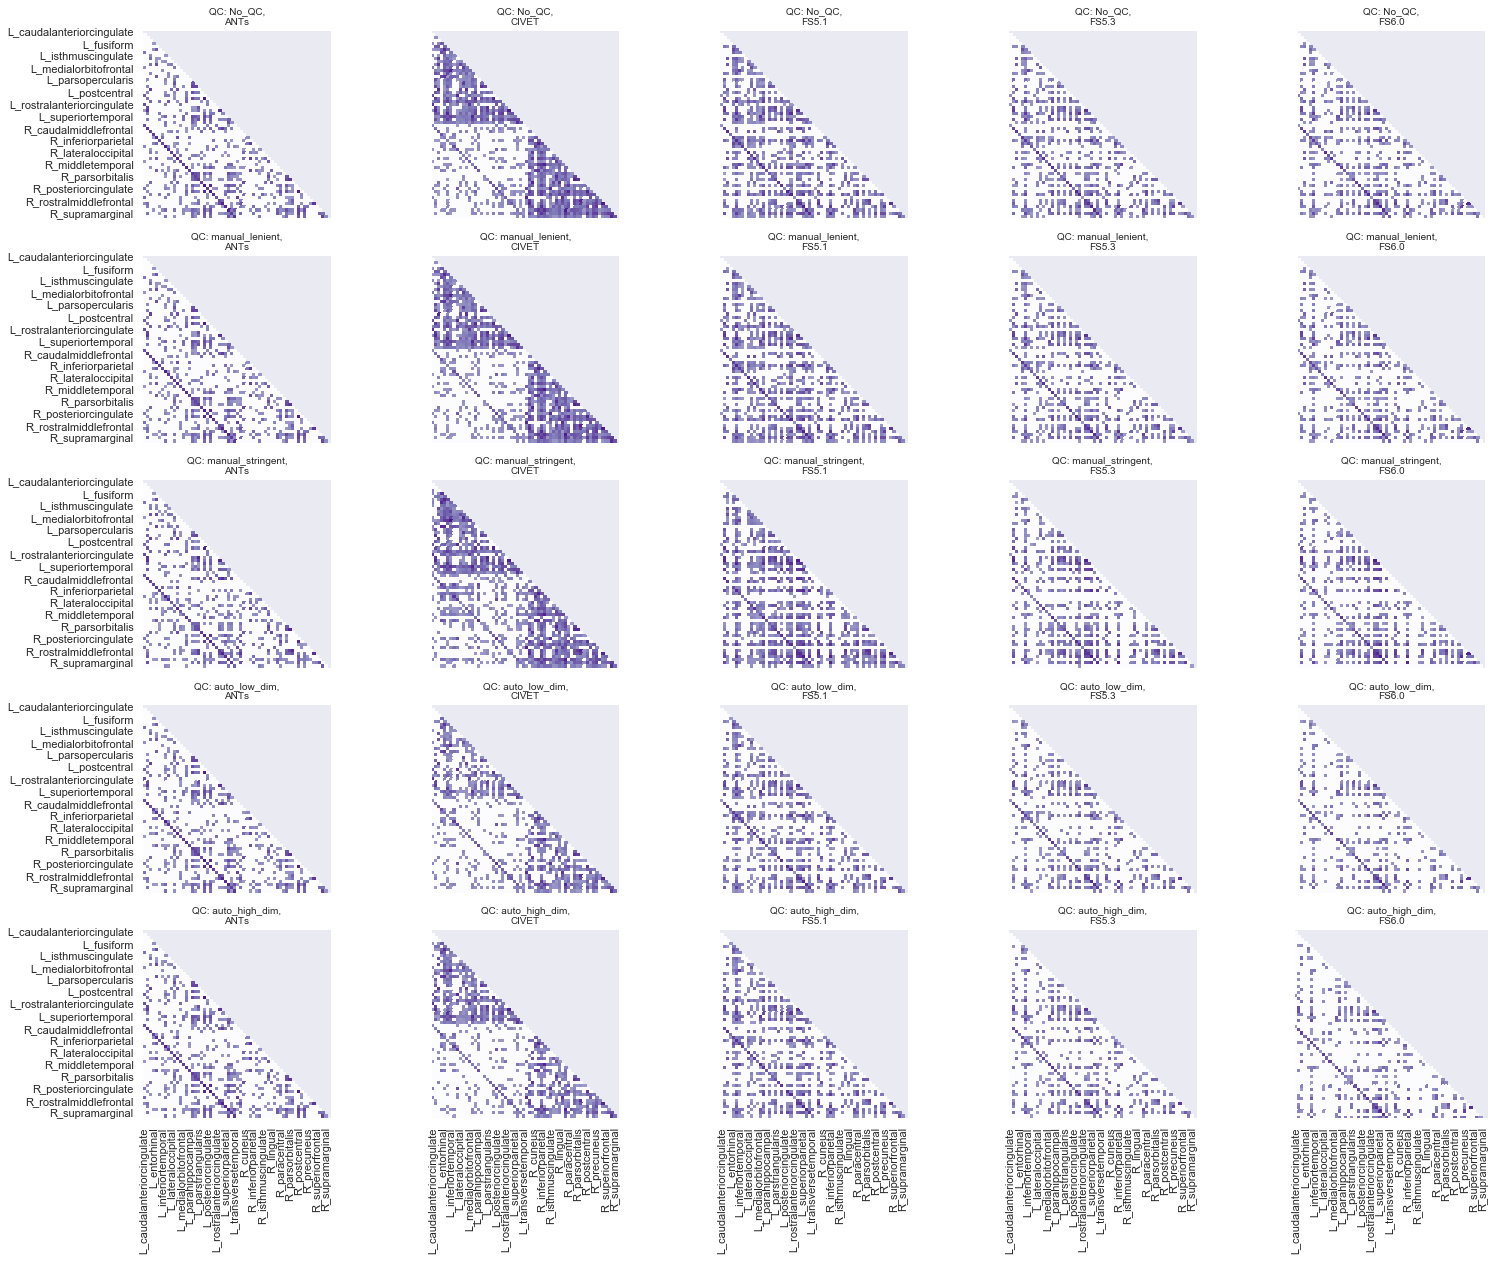

In [341]:
p_thresh= 0.05/(62*62/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

fig,axn = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(25, 20))
# Generate a custom diverging colormap
palette = 'Purples'#sns.xkcd_palette(["very light pink",'pinkish']) 
       
p=0
for qc in qc_list:
    master_df = master_df_dict[qc]

    for pipe in software_list:
        df = master_df[master_df[data_label]==pipe][[subject_ID_col]+common_roi_cols].copy()
        df_sorted = df.sort_index(1)
        #df_sorted = df.reindex(sorted(df.columns), axis=1)

        corr = df_sorted.corr()
        df_p_val = calculate_pvalues(df_sorted)
        corr[df_p_val >= p_thresh] = 0
        corr[corr < r_thresh] = 0
        print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

        # Plot
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

        
        with sns.axes_style("whitegrid"):
            sns.set(font_scale=0.5)
            g = sns.heatmap(corr, mask=mask, square=True, cmap=palette, ax=axn.flat[p],cbar=False)
            g.set_title('QC: {},\n{}'.format(qc,pipe),fontsize=10)
#             colorbar = g.collections[0].colorbar
#             colorbar.set_ticks([0.25,0.75])
#             colorbar.set_ticklabels(['0', '1'])
#             g.figure.axes[-1].tick_params(labelsize=20)
    
        p+=1

### Structrual covariance in resting state networks

In [31]:
network_map = pd.read_csv(data_dir + 'desikan-killiany_info.csv')
network_map['roi'] = network_map['hemisphere'] + '_' + network_map['label']
network_ordered_rois = list(network_map[network_map['roi'].isin(common_roi_cols)].sort_values(by=['hemisphere','yeo_7'])['roi'])

DKT_network_dict = {}
for network in network_map['yeo_7'].unique():
    network_rois = set(network_map[network_map['yeo_7']==network]['roi']) & set(common_roi_cols)    
    DKT_network_dict[network] = list(network_rois)
    print(network, len(network_rois))
    
print(network_map['yeo_7'].unique())

limbic 8
default mode 17
ventral attention 11
frontoparietal 3
somatomotor 10
dorsal attention 2
visual 11
subcortex 0
['limbic' 'default mode' 'ventral attention' 'frontoparietal'
 'somatomotor' 'dorsal attention' 'visual' 'subcortex']


In [108]:
def get_network_features(df, network_rois,threshold=True,p_thresh=0.05/(62*62/2),r_thresh=0.5):
    ''' Takes data df and filters using network ROIs.
        networks is a dictionary (name, list of rois)
    '''
    network_stats_df = pd.DataFrame(columns = ['n_nodes','n_edges','mean','centrality'],
                                    index = network_rois)
    network_df = df[network_rois].copy()
    network_mean = network_df.mean()
    
    df_sorted = network_df.sort_index(1)
    corr_df = network_df.corr()
    if threshold:
        df_p_val = calculate_pvalues(df_sorted)
        corr_df[df_p_val >= p_thresh] = 0
        corr_df[corr_df < r_thresh] = 0
    
    G = nx.from_pandas_adjacency(corr_df)
    #print(nx.info(G))
    G_centrality = nx.degree_centrality(G)
    
    network_stats_df['mean'] = network_mean
    network_stats_df['centrality'] = pd.Series(G_centrality)
    network_stats_df['n_nodes'] = G.number_of_nodes()
    network_stats_df['n_edges'] = G.number_of_edges()
    network_stats_df['graph_density'] = nx.density(G)
    
    return network_stats_df


### Plot basic network properties 
- n_nodes, n_edges, centrality

In [109]:
threshold = True
p_thresh = 0.05/(62*62/2)
r_thresh = 0.5
network_features_df_concat = pd.DataFrame()

for qc in qc_list:
    master_df = master_df_dict[qc]
    for pipe in software_list:
        for network_name, network_rois in DKT_network_dict.items():
            df = master_df[master_df[data_label]==pipe][network_rois].copy()
            
            for r_thresh in [0,0.25,0.5,0.75]:
                network_features_df = get_network_features(df, network_rois, threshold, p_thresh, r_thresh)
                network_features_df['network'] = network_name
                network_features_df['pipe'] = pipe
                network_features_df['qc'] = qc
                network_features_df['r_thresh'] = r_thresh
                network_features_df_concat = network_features_df_concat.append(network_features_df)

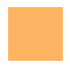

In [132]:
sns.palplot(['#fdb462'])

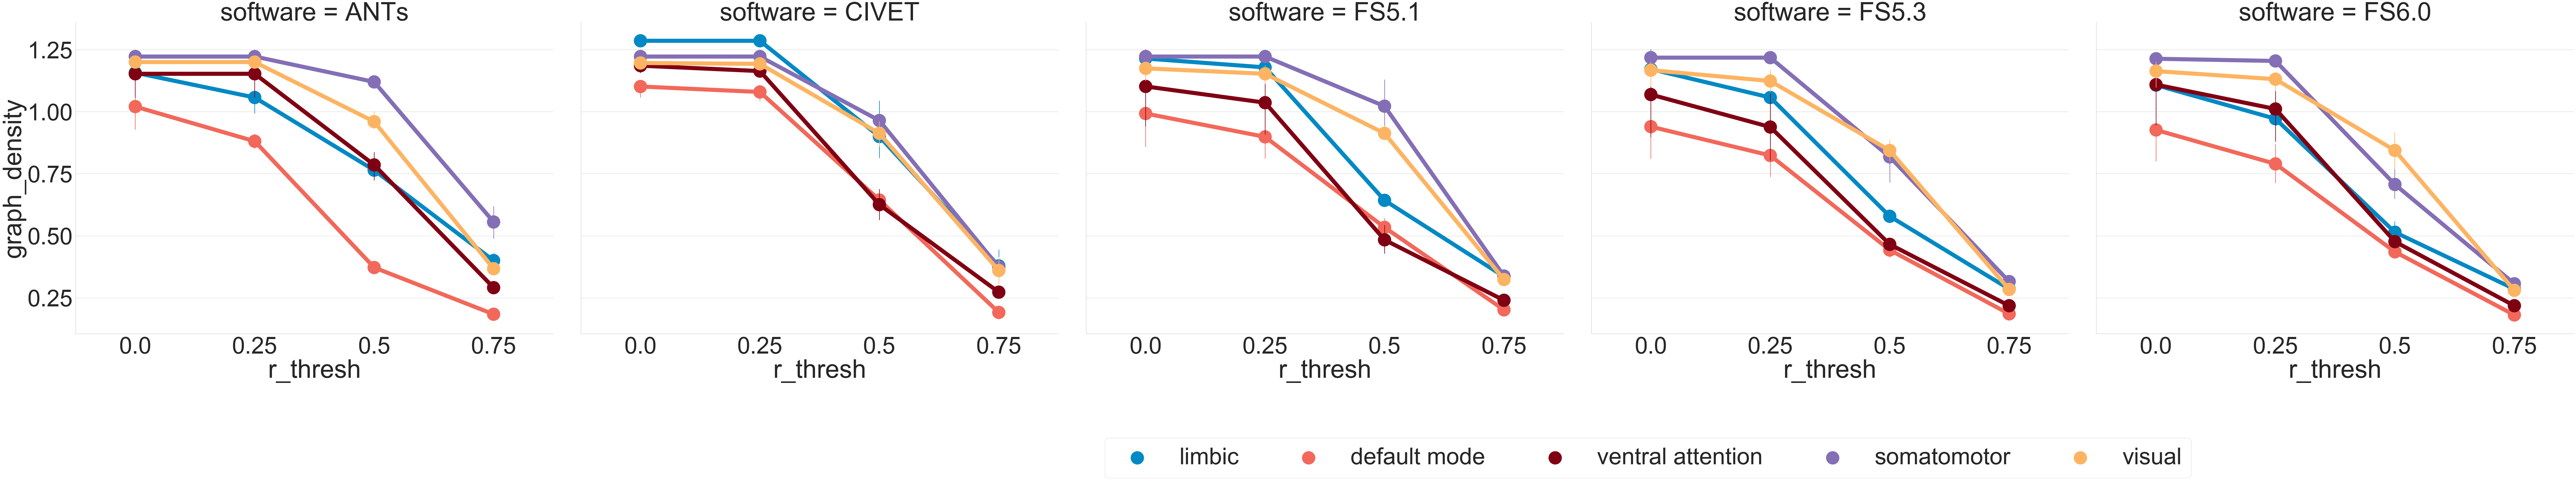

In [135]:
plot_df = network_features_df_concat[['r_thresh','network','pipe','qc','n_edges','n_nodes','graph_density']].copy().drop_duplicates()
plot_df = plot_df.rename(columns={'pipe':'software'})
sns.set(font_scale=7)
hue_order = ['limbic', 'default mode', 'ventral attention','somatomotor','visual']
#my_cmap = ["#0089c4","#fea7b4","#f2685a","#fdb462","#b3de69","#fea7b4","#f2685a","#800013"]
my_cmap = ["#0089c4","#f2685a","#800013","#846fb6","#fdb462"]
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='r_thresh',y='graph_density',hue='network', kind='point',data=plot_df,height=20,
                    hue_order=hue_order,col='software',palette=my_cmap,legend=False,scale=5,aspect=1.2,errwidth=2)
    #plt.setp(g, linewidth=2)
    plt.legend(loc='lower left',bbox_to_anchor=(-2.1,-0.5),ncol=7)

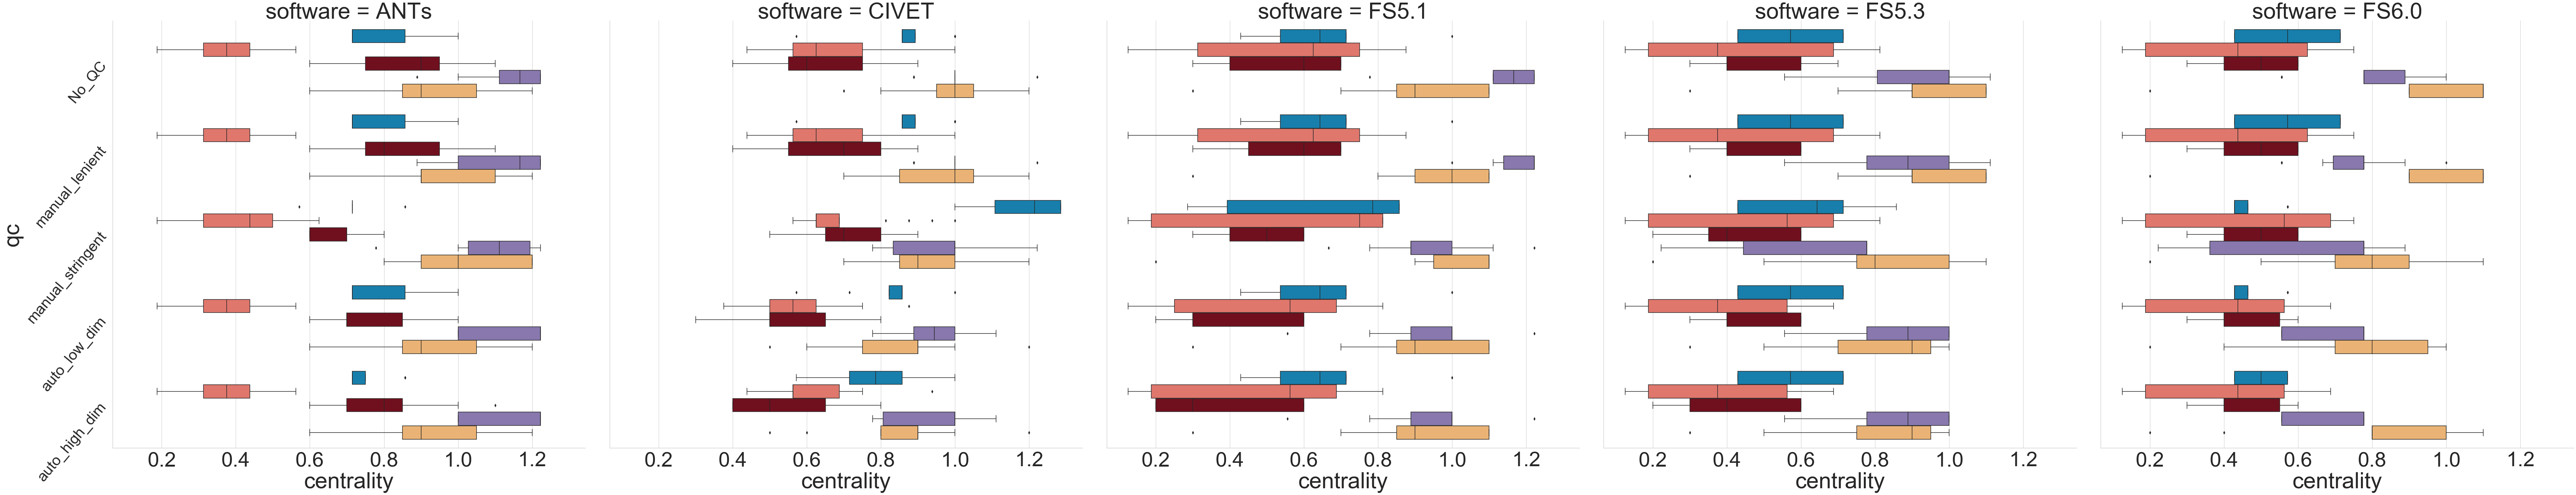

In [142]:
r_thresh = 0.5
plot_df = network_features_df_concat.copy().reset_index()
plot_df = plot_df.rename(columns={'pipe':'software'})
plot_df = plot_df[plot_df['r_thresh']==r_thresh]
sns.set(font_scale=5)
yorder = ['limbic', 'default mode', 'ventral attention','somatomotor','visual']
my_cmap = ["#0089c4","#f2685a","#800013","#846fb6","#fdb462"]

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='qc',x='centrality',hue='network', kind='box',data=plot_df,height=20,hue_order=yorder,
                   col='software',palette=my_cmap,legend=False)
    g.set_yticklabels(rotation=50,fontsize=40)
    #plt.legend(loc='lower left',bbox_to_anchor=(-2.1,-0.5),ncol=5)
    

### Plot network based structural covariance

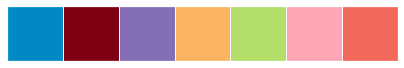

In [114]:
# my_cmap = ["#b3de69","#0089c4","#fea7b4","#f2685a","#846fb6","#fdb462","#800013","#b3de69","#f768a1","#9f9afa","#d10a1e","#34495e","#799c11","#fff200",
#            "#408080","#c8bfe7","#76cca8","#4c54b5","#a55ba6"]

my_cmap = ["#0089c4","#800013","#846fb6","#fdb462","#b3de69","#fea7b4","#f2685a"]
sns.palplot(my_cmap)

software: ANTs, qc: No_QC, corr_df_shape (62, 62)


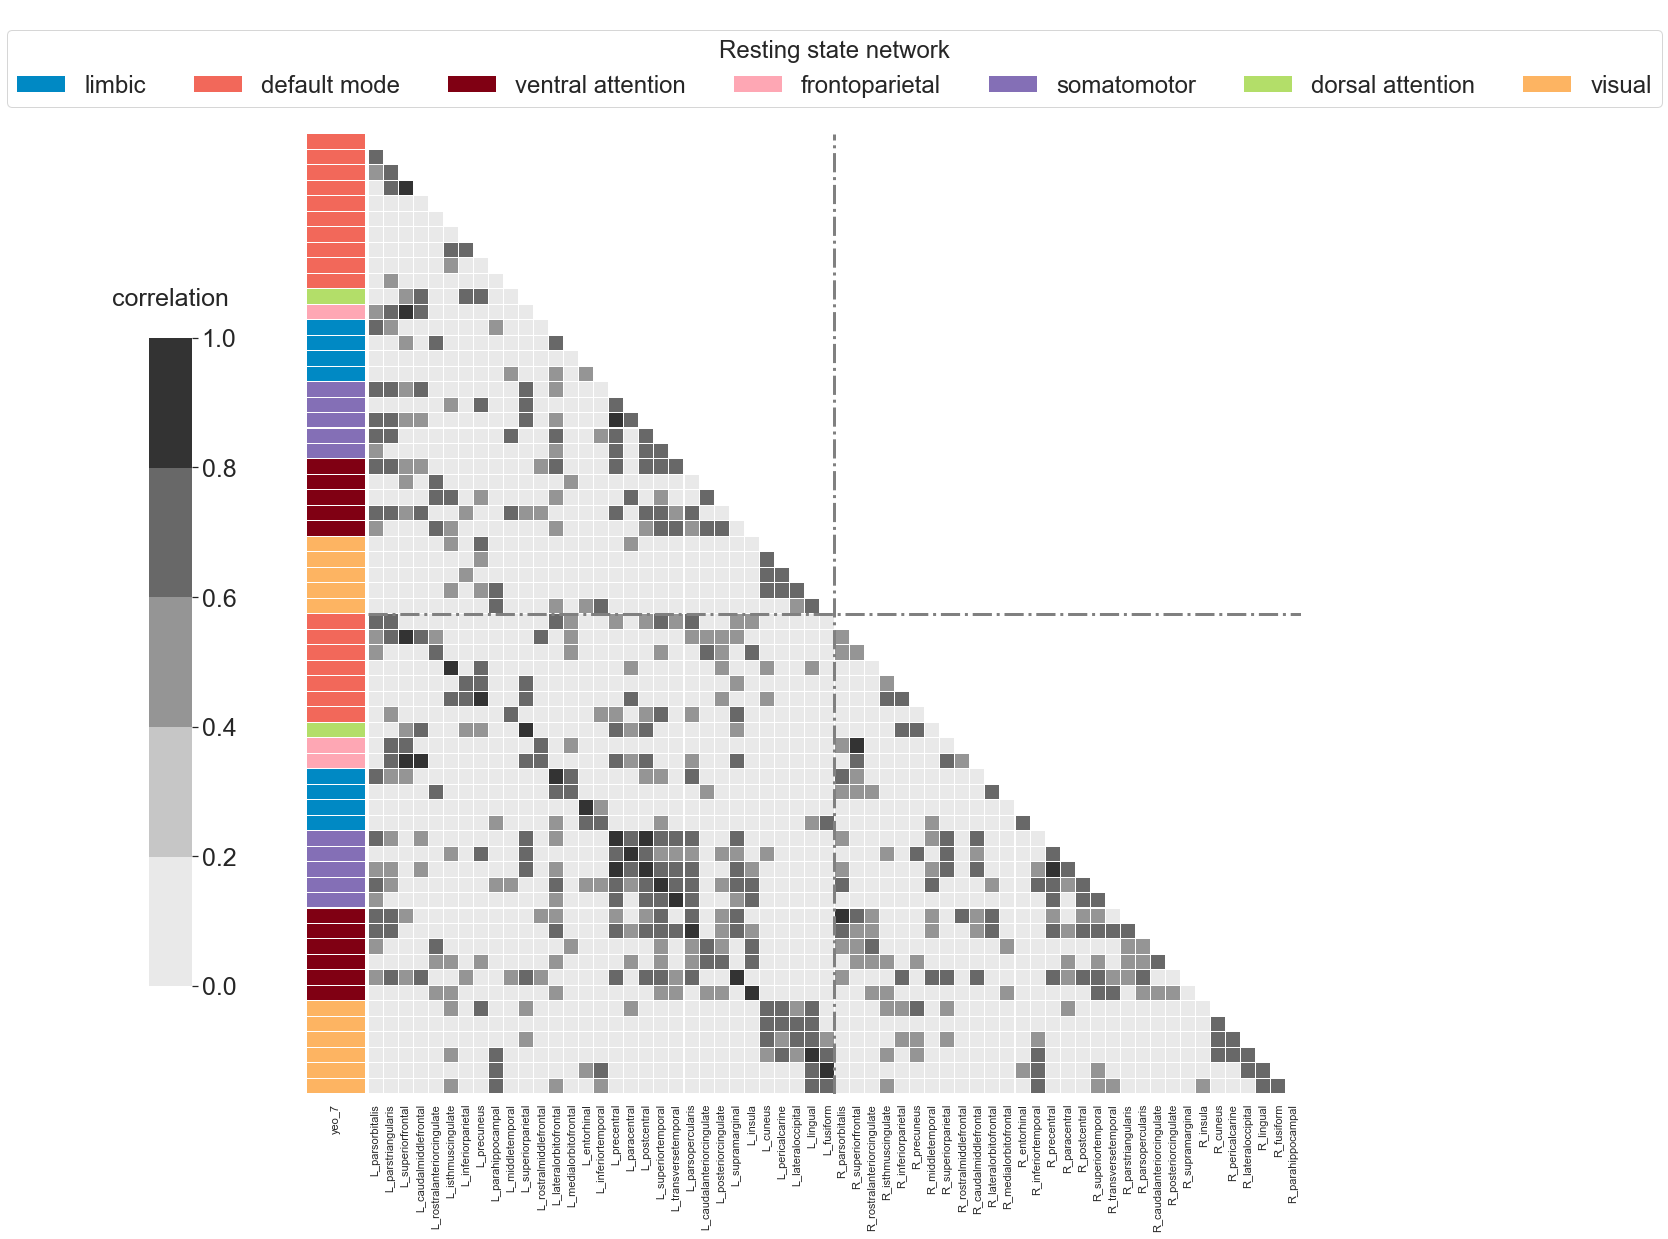

In [141]:
qc = 'No_QC'
#pipe = 'ANTs'

p_thresh = 0.05/(62*62/2)
r_thresh = 0.5

plot_row_label_legend = True

my_cmap = ["#0089c4","#800013","#846fb6","#fdb462","#b3de69","#fea7b4","#f2685a"]
palette_heat = sns.color_palette('Greys',5)
palette_rc1 = my_cmap

# row colors for injection site
DKT_network_df = network_map[network_map['roi'].isin(common_roi_cols)][['roi','yeo_7']].set_index('roi')
labels1 = DKT_network_df['yeo_7'].values
palette = sns.color_palette(palette_rc1,len(set(labels1))) 
lut1 = dict(zip(set(labels1), palette))
#rc1 = pd.DataFrame(index=DKT_network_df.index,data=labels1)[0].map(lut1)
rc1 = DKT_network_df['yeo_7'].map(lut1)

master_df = master_df_dict[qc]

for pipe in ['ANTs']: #software_list:
    if pipe == 'ANTs':
        plot_cbar = True
    else:
        plot_cbar = False

    if pipe == 'FS6.0':
        yticklabels = True
    else:
        yticklabels = False

    df = master_df[master_df[data_label]==pipe][[subject_ID_col]+common_roi_cols].copy()
    df_sorted = df[network_ordered_rois].copy()

    corr_df = df_sorted.corr()

    print('software: {}, qc: {}, corr_df_shape {}'.format(pipe,qc,corr_df.shape))

    df_p_val = calculate_pvalues(df_sorted)
    corr_df[df_p_val >= p_thresh] = 0
    corr_df[corr_df < r_thresh] = 0


    mask = np.zeros_like(corr_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.set(font_scale=1)
    figsize=(20,20)
    with sns.axes_style("whitegrid"):         
        g=sns.clustermap(corr_df, row_cluster=False, col_cluster=False, linewidths=0.05, cmap=palette_heat,
                         figsize=figsize, annot=False, row_colors=rc1, mask=mask, yticklabels=yticklabels, 
                         )  
        ax = g.ax_heatmap
        ax.hlines(corr_df.shape[1]//2, *ax.get_xlim(), linestyles = 'dashdot',linewidth=3, colors='grey') #"#fea7b4"
        ax.vlines(corr_df.shape[1]//2, *ax.get_ylim(), linestyles = 'dashdot',linewidth=3, colors="grey")
        ax.set_title('software = {}'.format(pipe), fontsize=50)

        if plot_cbar:
            cbar = ax.collections[0].colorbar
            cbar.ax.set_title('correlation\n',fontsize=25)
            cbar.ax.tick_params(labelsize=25)
            # Adjust the postion of the main colorbar for the heatmap
            g.cax.set_position([.1, .2, .03, .45])
        else:
            g.cax.set_visible(False)

        if plot_row_label_legend:
            # Draw the legend bar for the classes                 
            for label in DKT_network_df['yeo_7'].unique():
                g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)

            g.ax_col_dendrogram.legend(title='Resting state network', ncol=7, 
                                       loc='center',fontsize=24,title_fontsize=24)



#         fig_name = 'Structural_covar_network/Sturctural_covariance_network_{}_heatmap.png'.format(pipe)
#         save_path = '{}{}'.format(fig_dir,fig_name)
#         g.savefig(save_path, dpi=300)
#         print('Figure saved at {}'.format(save_path))

In [121]:
 DKT_network_df['yeo_7'].unique()

array(['limbic', 'default mode', 'ventral attention', 'frontoparietal',
       'somatomotor', 'dorsal attention', 'visual'], dtype=object)

### Covariance / Correlation between Individuals

Shapes df (683, 63), df_corr (683, 683)


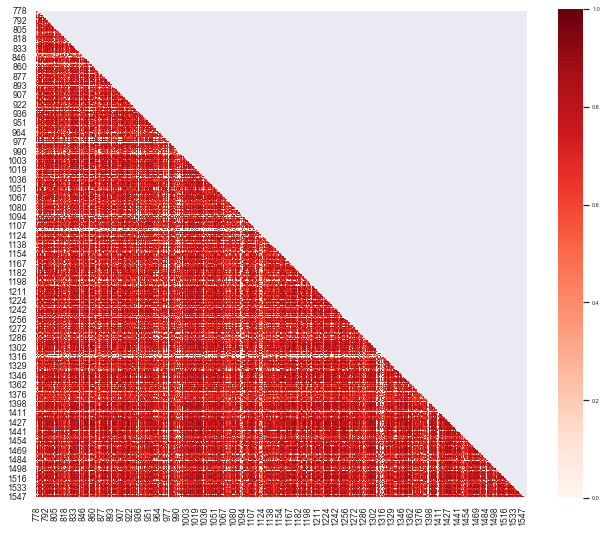

In [12]:
p_thresh= 0.05/(778*778/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

pipe = 'CIVET'
df = master_df[master_df[data_label]==pipe][[subject_ID_col]+common_roi_cols]
df_sorted = df.reindex(sorted(df.columns), axis=1)

corr = df_sorted[common_roi_cols].transpose().corr()
df_p_val = calculate_pvalues(df_sorted)
corr[df_p_val >= p_thresh] = 0
corr[corr < r_thresh] = 0
print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

# Plot
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'Reds'#sns.diverging_palette(220, 10, as_cmap=True)


with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(corr, mask=mask, cmap=cmap, square=True)


### TSNE

In [24]:
qc = 'auto'
master_df = master_df_dict[qc]

X = master_df[common_roi_cols].values
print(master_df.shape)

X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(3415, 68)


(3415, 2)

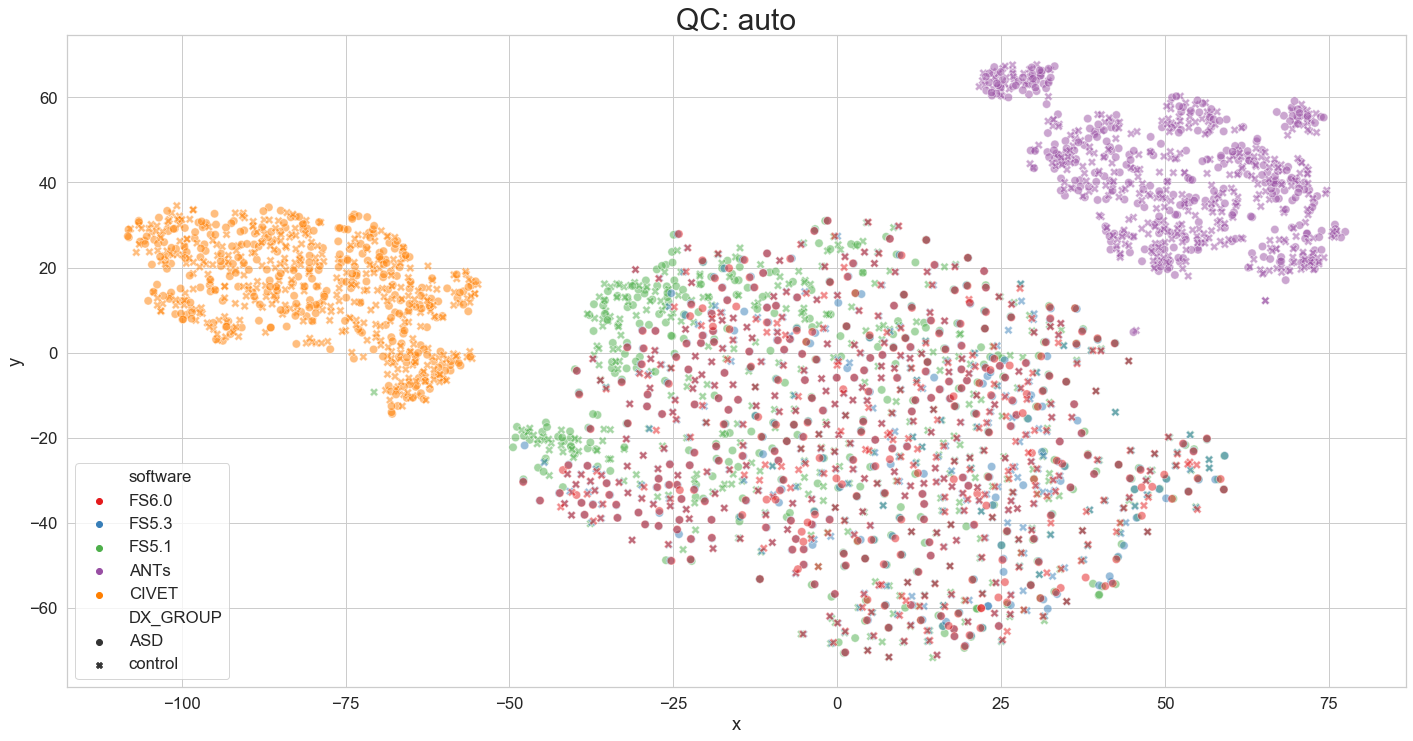

In [25]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
embed_df[data_label] = master_df[data_label].values
embed_df['DX_GROUP'] = master_df['DX_GROUP'].values
embed_df['DX_GROUP'] = embed_df['DX_GROUP'].replace({0:'control', 1:'ASD'})

plt.figure(figsize=(24,12))
sns.set(font_scale=1.52) 
hue_order = ['FS6.0','FS5.3','FS5.1','ANTs','CIVET']
with sns.axes_style("whitegrid"):
    g = sns.scatterplot(x='x',y='y',hue=data_label,hue_order=hue_order, style='DX_GROUP', s=70, alpha=0.5,
                    data=embed_df,palette="Set1")
    g.legend(loc=3)
    plt.title('QC: {}'.format(qc),fontsize=30)
    #g.figure.savefig('/Users/nikhil/Desktop/tsne.png', dpi=300)

### Subject clustering

In [10]:
qc = 'No_QC'
master_df = master_df_dict[qc]

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'
n_clusters = 2
normalize_data = False # Doesn't help with euclidean and destroys correlation 

cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=similarity, linkage=linkage)

cluster_stat_dict = {} #stores orig membership labels and overlap estimate from bootstrap 
for pipe in master_df[data_label].unique():
    cluster_df = master_df[master_df[data_label]==pipe].copy().reset_index(drop=True)
    X = cluster_df[common_roi_cols].values
    if normalize_data:
        X = X - X.mean(axis=0)
        
    L_pairwise, overlap = get_bootstrapped_membership_overlap_distribution(X, cluster, n_boot=100)
    
    print('{}, cluster_df shape {}, average overlap from bootstrap clusters {:4.3f}'.format(pipe, cluster_df.shape, np.mean(overlap)))
    cluster_stat_dict[pipe] = (L_pairwise,overlap)

ANTs, cluster_df shape (778, 68), average overlap from bootstrap clusters 0.797
CIVET, cluster_df shape (778, 68), average overlap from bootstrap clusters 0.717
FS5.1, cluster_df shape (778, 68), average overlap from bootstrap clusters 0.780
FS5.3, cluster_df shape (778, 68), average overlap from bootstrap clusters 0.703
FS6.0, cluster_df shape (778, 68), average overlap from bootstrap clusters 0.619


In [11]:
possible_pairs = list(itertools.combinations(cluster_stat_dict.keys(), 2))
table_df = pd.DataFrame(columns=software_list,index=software_list)

for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    
    c_membership1 = cluster_stat_dict[pipe1][0]
    n_samples = c_membership1.shape[0]
    n_unique_pairs = n_samples*(n_samples-1)/2
    
    c_membership2 = cluster_stat_dict[pipe2][0]
    
    pairwise_membership_consistancy = c_membership1 == c_membership2
    
    overlap = np.triu(pairwise_membership_consistancy,k=1).sum()/n_unique_pairs   
   
    # 'Expected overlap from bootstrapping'
    bootstrap_overlap1 = np.mean(cluster_stat_dict[pipe1][1])
    bootstrap_overlap2 = np.mean(cluster_stat_dict[pipe2][1])
    table_df.loc[pipe1,pipe1] = bootstrap_overlap1.round(3)
    table_df.loc[pipe2,pipe2] = bootstrap_overlap2.round(3)
        
    # Cross-software overlap
    table_df.loc[pipe1,pipe2] = overlap.round(3)
    table_df.loc[pipe2,pipe1] = overlap.round(3)
    
print('\n Clustering consistency between software tools')
table_df


 Clustering consistency between software tools


,ANTs,CIVET,FS5.1,FS5.3,FS6.0
ANTs,0.797,0.5,0.521,0.517,0.522
CIVET,0.5,0.717,0.5,0.5,0.5
FS5.1,0.521,0.5,0.78,0.609,0.529
FS5.3,0.517,0.5,0.609,0.703,0.499
FS6.0,0.522,0.5,0.529,0.499,0.619


In [ ]:
ANTs 	CIVET 	FS5.1 	FS5.3 	FS6.0
ANTs 	0.798 	0.5 	0.521 	0.517 	0.522
CIVET 	0.5 	0.704 	0.5 	0.5 	0.5
FS5.1 	0.521 	0.5 	0.765 	0.609 	0.529
FS5.3 	0.517 	0.5 	0.609 	0.694 	0.499
FS6.0 	0.522 	0.5 	0.529 	0.499 	0.624

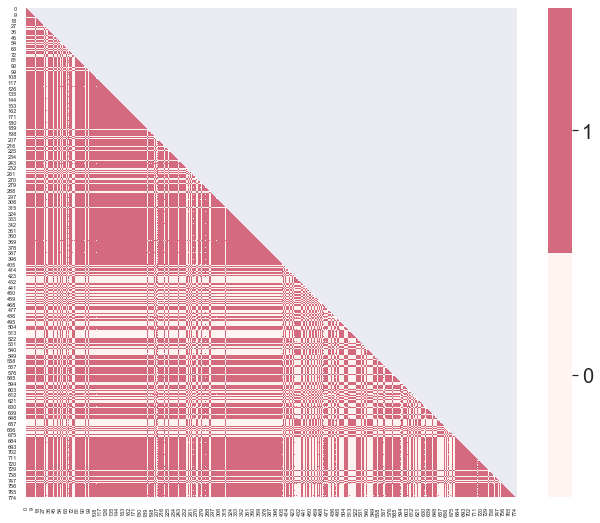

In [16]:
# Plot subject-pairs heatmap
pipe = 'FS6.0'
c_membership = cluster_stat_dict[pipe][0]

# Generate a mask for the upper triangle
mask = np.zeros_like(c_membership, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.xkcd_palette(["very light pink",'pinkish']) #sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(c_membership, mask=mask, cmap=cmap, square=True)
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(['0', '1'])
    g.figure.axes[-1].tick_params(labelsize=20)

### Clustering simulation

In [107]:
clust_dist = 'Corr'
if clust_dist == 'Euclidean':
    n_points = 6
    shift = 2

    x1 = np.arange(0,n_points,1)
    y1 = np.arange(0,n_points,1)
    z1 = np.arange(0,n_points,1)
    w1 = np.arange(0,n_points,1)
    xx1,yy1,zz1,ww1 = np.meshgrid(x1, y1, z1, w1)

    x2 = np.arange(n_points+shift,2*n_points+shift,1)
    y2 = np.arange(n_points+shift,2*n_points+shift,1)
    z2 = np.arange(n_points+shift,2*n_points+shift,1)
    w2 = np.arange(n_points+shift,2*n_points+shift,1)
    xx2,yy2,zz2,ww2 = np.meshgrid(x2, y2, z2, w2)

    # Stack two grids
    a = np.array(list(zip(xx1.ravel(),yy2.ravel(),zz1.ravel(),ww1.ravel())))
    b = np.array(list(zip(xx2.ravel(),yy2.ravel(),zz2.ravel(),ww2.ravel())))
    c = np.vstack([a,b])
    print(a.mean(),b.mean(),c.shape)

elif clust_dist == 'Corr':
    n_points = 100
    n_dim = 10
    x1 = np.random.rand(n_dim,1)
    x1 = np.repeat(x1,n_points, axis=1)

    y1 = np.random.rand(n_dim,1)
    y1 = np.repeat(y1,n_points, axis=1)

    a = x1*(0.1*np.arange(1,n_points+1,1))
    b = y1*(0.1*np.arange(1,n_points+1,1))

    c = np.vstack([a.T,b.T])
    print(x1.mean(),y1.mean(),a.mean(),b.mean(),a.shape,b.shape,c.shape)

else:
    print('unknown distance metric')

0.5777617361724394 0.6518703849485468 2.9176967676708196 3.291945443990161 (10, 100) (10, 100) (200, 10)


In [110]:
similarity = 'correlation'#'euclidean' #correlation
linkage = 'average'
n_clusters = 2
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=similarity, linkage=linkage)

L_pairwise, overlap = get_bootstrapped_membership_overlap_distribution(c, cluster, n_boot=100)
L_pairwise.shape, np.mean(overlap)

((200, 200), 1.0)

### Compare ML performance 

In [93]:
# Start time
start = time.time()

ml_results_dir = results_dir + 'ml2/software/'

save_perf = False
rank_features = False
compute_null = 100 #Either False or number of permutations 

model_type = 'regression'
cv_type = 'shuffle_split'
group_col = False #This is only true for BrainAge type analysis

ml_perf_concat = pd.DataFrame()
feature_rank_df_concat = pd.DataFrame()

for qc in ['No_QC']: #qc_list:
    master_df = master_df_dict[qc]
    roi_cols = common_roi_cols

    if model_type.lower() == 'regression':
        for dx_grp in [0,1]:
            print('\nUsing qc {}, and Dx {}'.format(qc,dx_grp))
            ml_master_df = master_df[master_df['DX_GROUP']==dx_grp]
            outcome_col = 'AGE_AT_SCAN'            
            covar_continuous_cols = []
            covar_cat_cols = ['SEX','SITE_ID'] 
            model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
            ml_perf,perf_pval_dict,feature_rank_df,_ = computeSoftwareMLModels(ml_master_df,data_label,roi_cols,covar_continuous_cols,
                                                                             covar_cat_cols,outcome_col,group_col,model_type,model,
                                                                             rank_features,compute_null,n_jobs=4)

            ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
            ml_perf['qc'] = np.tile(qc,len(ml_perf))
            ml_perf_concat = ml_perf_concat.append(ml_perf)
            
            feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
            feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
            feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        
    else: 
        print('\nUsing qc {}'.format(qc))
        ml_master_df = master_df

        outcome_col = 'DX_GROUP'
        covar_continuous_cols = ['AGE_AT_SCAN']
        covar_cat_cols = ['SEX','SITE_ID'] 
        #model = svm.SVC(kernel='linear')
        model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

        ml_perf,perf_pval_dict,feature_rank_df = computeSoftwareMLModels(ml_master_df,roi_cols,covar_continuous_cols,covar_cat_cols,
                                                                         outcome_col,group_col,model_type,model,n_jobs=-1)

        ml_perf['qc'] = np.tile(qc,len(ml_perf))
        ml_perf_concat = ml_perf_concat.append(ml_perf)
        
        feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
        feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
        feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        
if save_perf:
    
    # Predictions
    save_path = '{}Software_DKT_ml_pred_perf_QC_auto_high_dim_{}_{}_{}.pkl'.format(ml_results_dir,outcome_col,model_type,cv_type)
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    save_df = ml_perf_concat
    save_df.to_pickle(save_path)
    
    # Features
    save_path = '{}Software_DKT_ml_feature_imp_QC_auto_high_dim_{}_{}_{}.pkl'.format(ml_results_dir,outcome_col,model_type,cv_type)
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    save_df = feature_rank_df_concat[(feature_rank_df_concat['predictor'].isin(roi_cols))]
    save_df = save_df.rename(columns={'predictor':'roi'})
    save_df.to_pickle(save_path)
        
    
end = time.time()
print('Run duration:')
print((end - start)/60.0)


Using qc No_QC, and Dx 0
Running ML classifer on 5 software
software ANTs
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-36.131, sd:10.408
software CIVET
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-42.692, sd:10.701
software FS5.1
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-33.110, sd:10.986
software FS5.3
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_m

{'ANTs': 0.009900990099009901, 'CIVET': 0.009900990099009901, 'FS5.1': 0.009900990099009901, 'FS5.3': 0.009900990099009901, 'FS6.0': 0.009900990099009901}


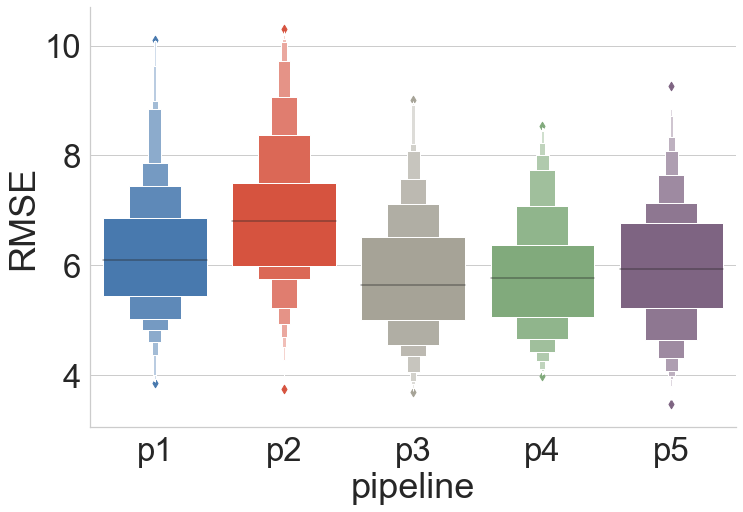

In [105]:
# plot ML performance
print(perf_pval_dict)
x_order = ['p1','p2','p3','p4','p5'] #software_list + ['null']
col_order = qc_list 
colors = ["windows blue", "tomato", "greyish", "faded green", "dusty purple","dark grey"]
palette = sns.xkcd_palette(colors) #'Paired' #sns.xkcd_palette(colors)
sns.set(font_scale=2)
    
plot_df = ml_perf_concat.copy()

plot_df = plot_df.rename(columns={'software':'pipeline'})
plot_df['pipeline'] = plot_df['pipeline'].replace({'ANTs':'p1','CIVET':'p2','FS5.1':'p3','FS5.3':'p4','FS6.0':'p5'})


if model_type.lower() == 'regression':
    plot_df['RMSE'] = np.sqrt(-1*plot_df['neg_mean_squared_error'])
    plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
    
    sns.set(font_scale=3)
    with sns.axes_style("whitegrid"): 
        g = sns.catplot(y='RMSE',x='pipeline', kind='boxen',
                        order=x_order,palette=palette,height=8, aspect=1.4,legend=True,data=plot_df)
#         g = sns.catplot(y='RMSE',x=data_label, hue='DX_GROUP', kind='boxen',col='qc',col_order=col_order,col_wrap=2,
#                         order=x_order,palette=palette,height=8, aspect=1.4,legend=True,data=plot_df)
        #plt.legend(loc='upper right')
else:
    with sns.axes_style("white"): 
        g = sns.catplot(y='roc_auc',x=data_label, hue='DX_GROUP', kind='boxen',data=plot_df,col='qc',col_order=col_order,
                        order=x_order,palette=palette,height=20, aspect=1.1,legend=False)
#         plt.legend(loc='upper right')

### BrainAge type analysis
- Training models on controls and testing on ASDs

In [35]:
model_type = 'regression'
cv_type = 'shuffle_split'
group_col = 'DX_GROUP'

ml_perf_concat = pd.DataFrame()
feature_rank_df_concat = pd.DataFrame()
rank_features = False
compute_null = False

external_scores_concat_df = pd.DataFrame()
for qc in qc_list:
    master_df = master_df_dict[qc]
    master_df['DX_GROUP'] = master_df['DX_GROUP'].replace({0:'internal', 1:'external'})
    roi_cols = common_roi_cols

    print('\nUsing qc {}'.format(qc))
    ml_master_df = master_df
    outcome_col = 'AGE_AT_SCAN'
    covar_continuous_cols = []
    covar_cat_cols = ['SEX','SITE_ID'] 
    model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
    ml_perf,perf_pval_dict,feature_rank_df,external_scores = computeSoftwareMLModels(ml_master_df,data_label,roi_cols,covar_continuous_cols,
                                                                     covar_cat_cols,outcome_col,group_col,model_type,model,
                                                                     rank_features,compute_null,n_jobs=-1)
    external_scores['qc'] = np.tile(qc,len(external_scores))  
    external_scores_concat_df = external_scores_concat_df.append(external_scores)
    
    


Using qc No_QC
Running ML classifer on 5 software
software ANTs
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (778, 81), y 778 (18.09m, 8.23sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-42.715, sd:9.272
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (778, 81), y 778 (18.09m, 8.23sd)
Using regression model with perf metric neg_mean_squared_error
software CIVET
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (778, 81), y 778 (18.09m, 8.23sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-45.590, sd:11.804
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (778, 81), y 778 (18.09m, 8.23sd)
Using regression model with perf metric neg_mean_squared_error
software FS5.1
Using ['SEX', 'SITE_ID'] categorical c

software FS5.3
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (683, 80), y 683 (16.07m, 5.30sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-16.422, sd:2.984
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (683, 80), y 683 (16.07m, 5.30sd)
Using regression model with perf metric neg_mean_squared_error
software FS6.0
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (683, 80), y 683 (16.07m, 5.30sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-17.137, sd:3.327
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (683, 80), y 683 (16.07m, 5.30sd)
Using regression model with perf metric neg_mean_squared_error


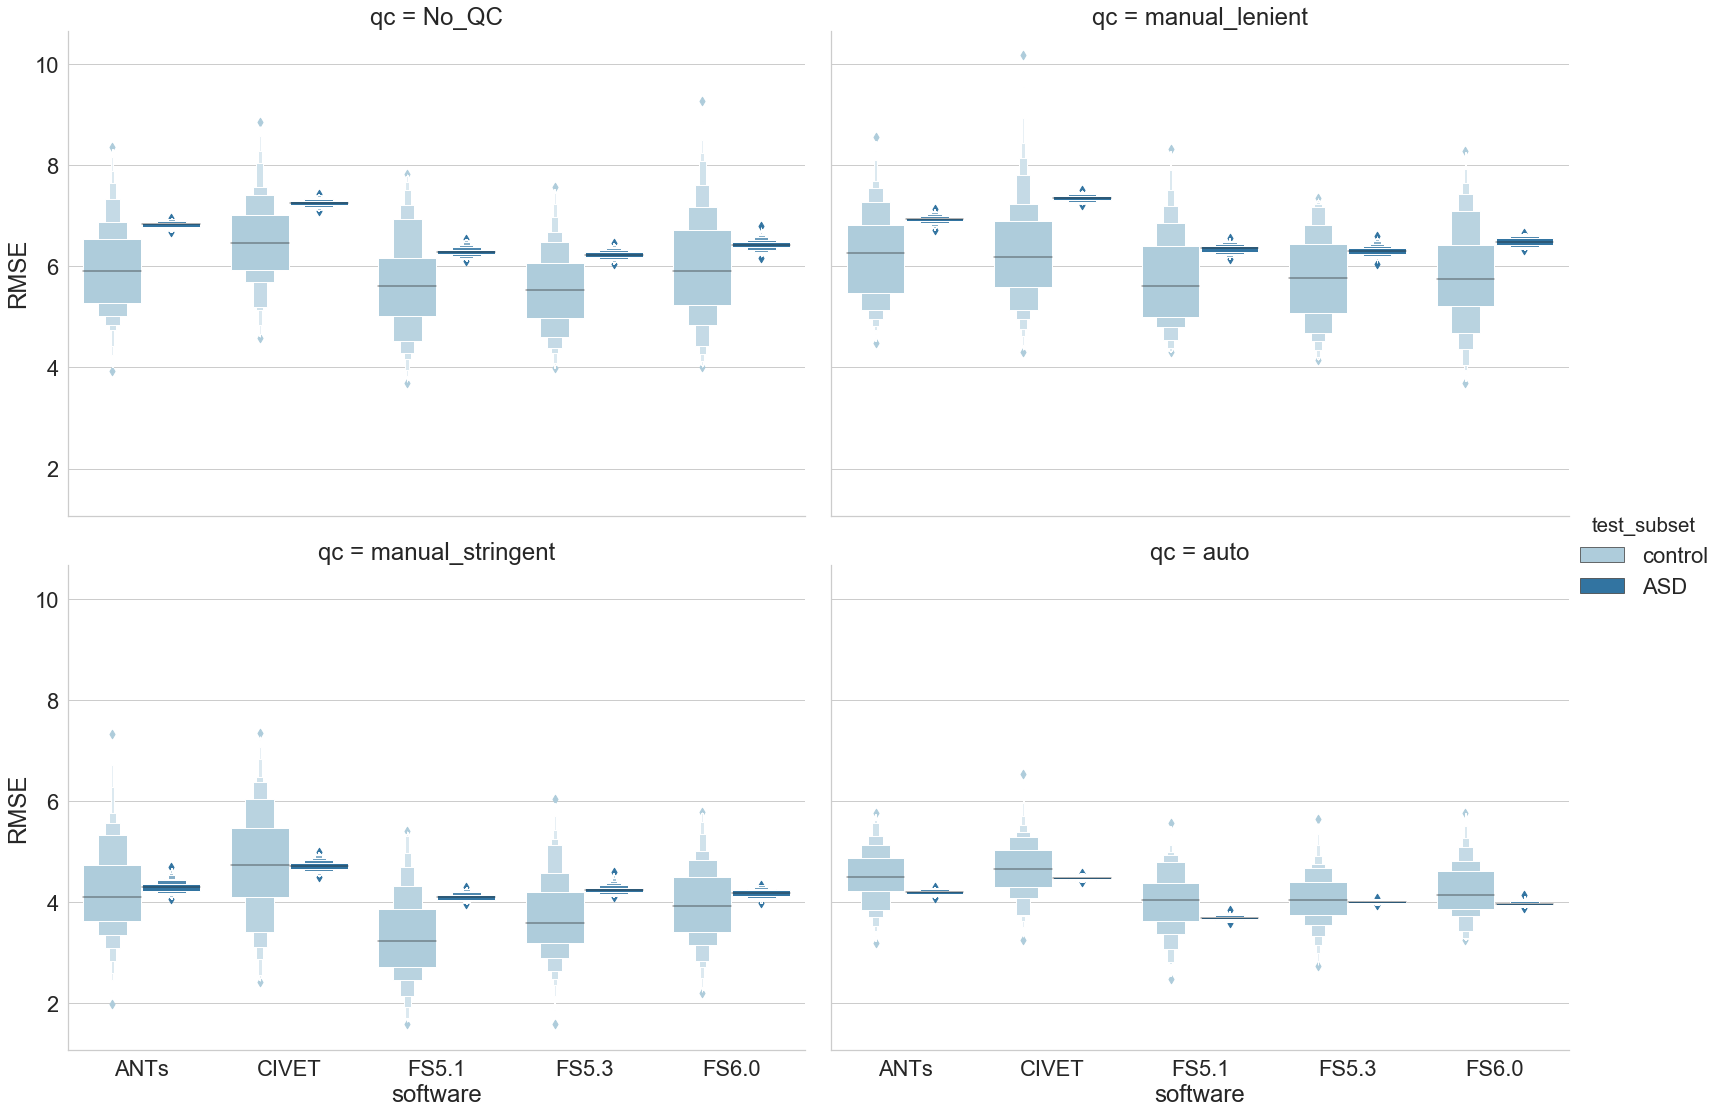

In [36]:
plot_df = external_scores_concat_df.copy()
col_order = qc_list 
x_order = software_list 

palette = 'Paired'
sns.set(font_scale=2)

if model_type.lower() == 'regression':
    plot_df['RMSE'] = np.sqrt(plot_df['neg_mean_squared_error'])
    plot_df['test_subset'] = plot_df['test_subset'].replace({'internal':'control', 'external':'ASD'})
    
    with sns.axes_style("whitegrid"): 
        g = sns.catplot(y='RMSE',x=data_label, hue='test_subset', kind='boxen',col='qc',col_order=col_order,col_wrap=2,
                        order=x_order,palette=palette,height=8, aspect=1.4,legend=True,data=plot_df)
    

### Get ML based feature importance
- verfied rerunning stability. For a sprcified random_state in CV, RFECV returns identical output.

In [32]:
feature_count_df = pd.DataFrame(columns=['count',data_label,'DX_GROUP','qc'])
i = 0
roi_cols = common_roi_cols
for pipe in ml_master_df[data_label].unique():
    for qc in feature_rank_df_concat['qc'].unique():
        for dx in [0,1]:
            n_feat = len(feature_rank_df_concat[(feature_rank_df_concat[data_label] == pipe) &                              
                                                (feature_rank_df_concat['rank'] == 1) &                              
                                                (feature_rank_df_concat['predictor'].isin(roi_cols)) & 
                                                (feature_rank_df_concat['qc'] == qc) &
                                                (feature_rank_df_concat['DX_GROUP'] == dx)])
            feature_count_df.loc[i] = [n_feat,pipe,dx,qc]
            i+=1
            print('Pipeline {}, n_roi {}, qc {}, dx {}, n_feat {}\n'.format(pipe,len(roi_cols),qc,dx,n_feat))

Pipeline ANTs, n_roi 62, qc No_QC, dx 0, n_feat 13

Pipeline ANTs, n_roi 62, qc No_QC, dx 1, n_feat 25

Pipeline ANTs, n_roi 62, qc manual_lenient, dx 0, n_feat 13

Pipeline ANTs, n_roi 62, qc manual_lenient, dx 1, n_feat 35

Pipeline ANTs, n_roi 62, qc manual_stringent, dx 0, n_feat 42

Pipeline ANTs, n_roi 62, qc manual_stringent, dx 1, n_feat 9

Pipeline ANTs, n_roi 62, qc auto_low_dim, dx 0, n_feat 20

Pipeline ANTs, n_roi 62, qc auto_low_dim, dx 1, n_feat 55

Pipeline ANTs, n_roi 62, qc auto_high_dim, dx 0, n_feat 17

Pipeline ANTs, n_roi 62, qc auto_high_dim, dx 1, n_feat 21

Pipeline CIVET, n_roi 62, qc No_QC, dx 0, n_feat 18

Pipeline CIVET, n_roi 62, qc No_QC, dx 1, n_feat 56

Pipeline CIVET, n_roi 62, qc manual_lenient, dx 0, n_feat 60

Pipeline CIVET, n_roi 62, qc manual_lenient, dx 1, n_feat 50

Pipeline CIVET, n_roi 62, qc manual_stringent, dx 0, n_feat 26

Pipeline CIVET, n_roi 62, qc manual_stringent, dx 1, n_feat 43

Pipeline CIVET, n_roi 62, qc auto_low_dim, dx 0, n_fe

In [33]:
agg_important_feat = []
for pipe in feature_rank_df_concat[data_label].unique():
    df = feature_rank_df_concat[feature_rank_df_concat[data_label]==pipe]
    agg_important_feat += list(df[df['rank']==1]['predictor'].values)

print(set(agg_important_feat))     

{'R_inferiortemporal', 'L_insula', 'SITE_ID_NYU', 'SITE_ID_PITT', 'R_isthmuscingulate', 'L_caudalanteriorcingulate', 'L_precuneus', 'R_lingual', 'L_supramarginal', 'SITE_ID_UM_2', 'L_middletemporal', 'L_pericalcarine', 'L_precentral', 'R_cuneus', 'R_entorhinal', 'R_transversetemporal', 'L_lateralorbitofrontal', 'L_superiorfrontal', 'SITE_ID_OLIN', 'R_caudalanteriorcingulate', 'R_rostralanteriorcingulate', 'R_inferiorparietal', 'L_rostralanteriorcingulate', 'R_posteriorcingulate', 'SITE_ID_UCLA_2', 'L_inferiortemporal', 'L_medialorbitofrontal', 'SEX', 'R_precuneus', 'SITE_ID_MAX_MUN', 'L_isthmuscingulate', 'R_fusiform', 'R_superiorparietal', 'SITE_ID_TRINITY', 'SITE_ID_UM_1', 'SITE_ID_YALE', 'R_superiortemporal', 'R_superiorfrontal', 'R_rostralmiddlefrontal', 'L_posteriorcingulate', 'SITE_ID_SDSU', 'SITE_ID_SBL', 'L_lingual', 'SITE_ID_USM', 'L_cuneus', 'L_caudalmiddlefrontal', 'L_parsopercularis', 'R_paracentral', 'R_precentral', 'L_parstriangularis', 'SITE_ID_LEUVEN_2', 'R_parahippocam

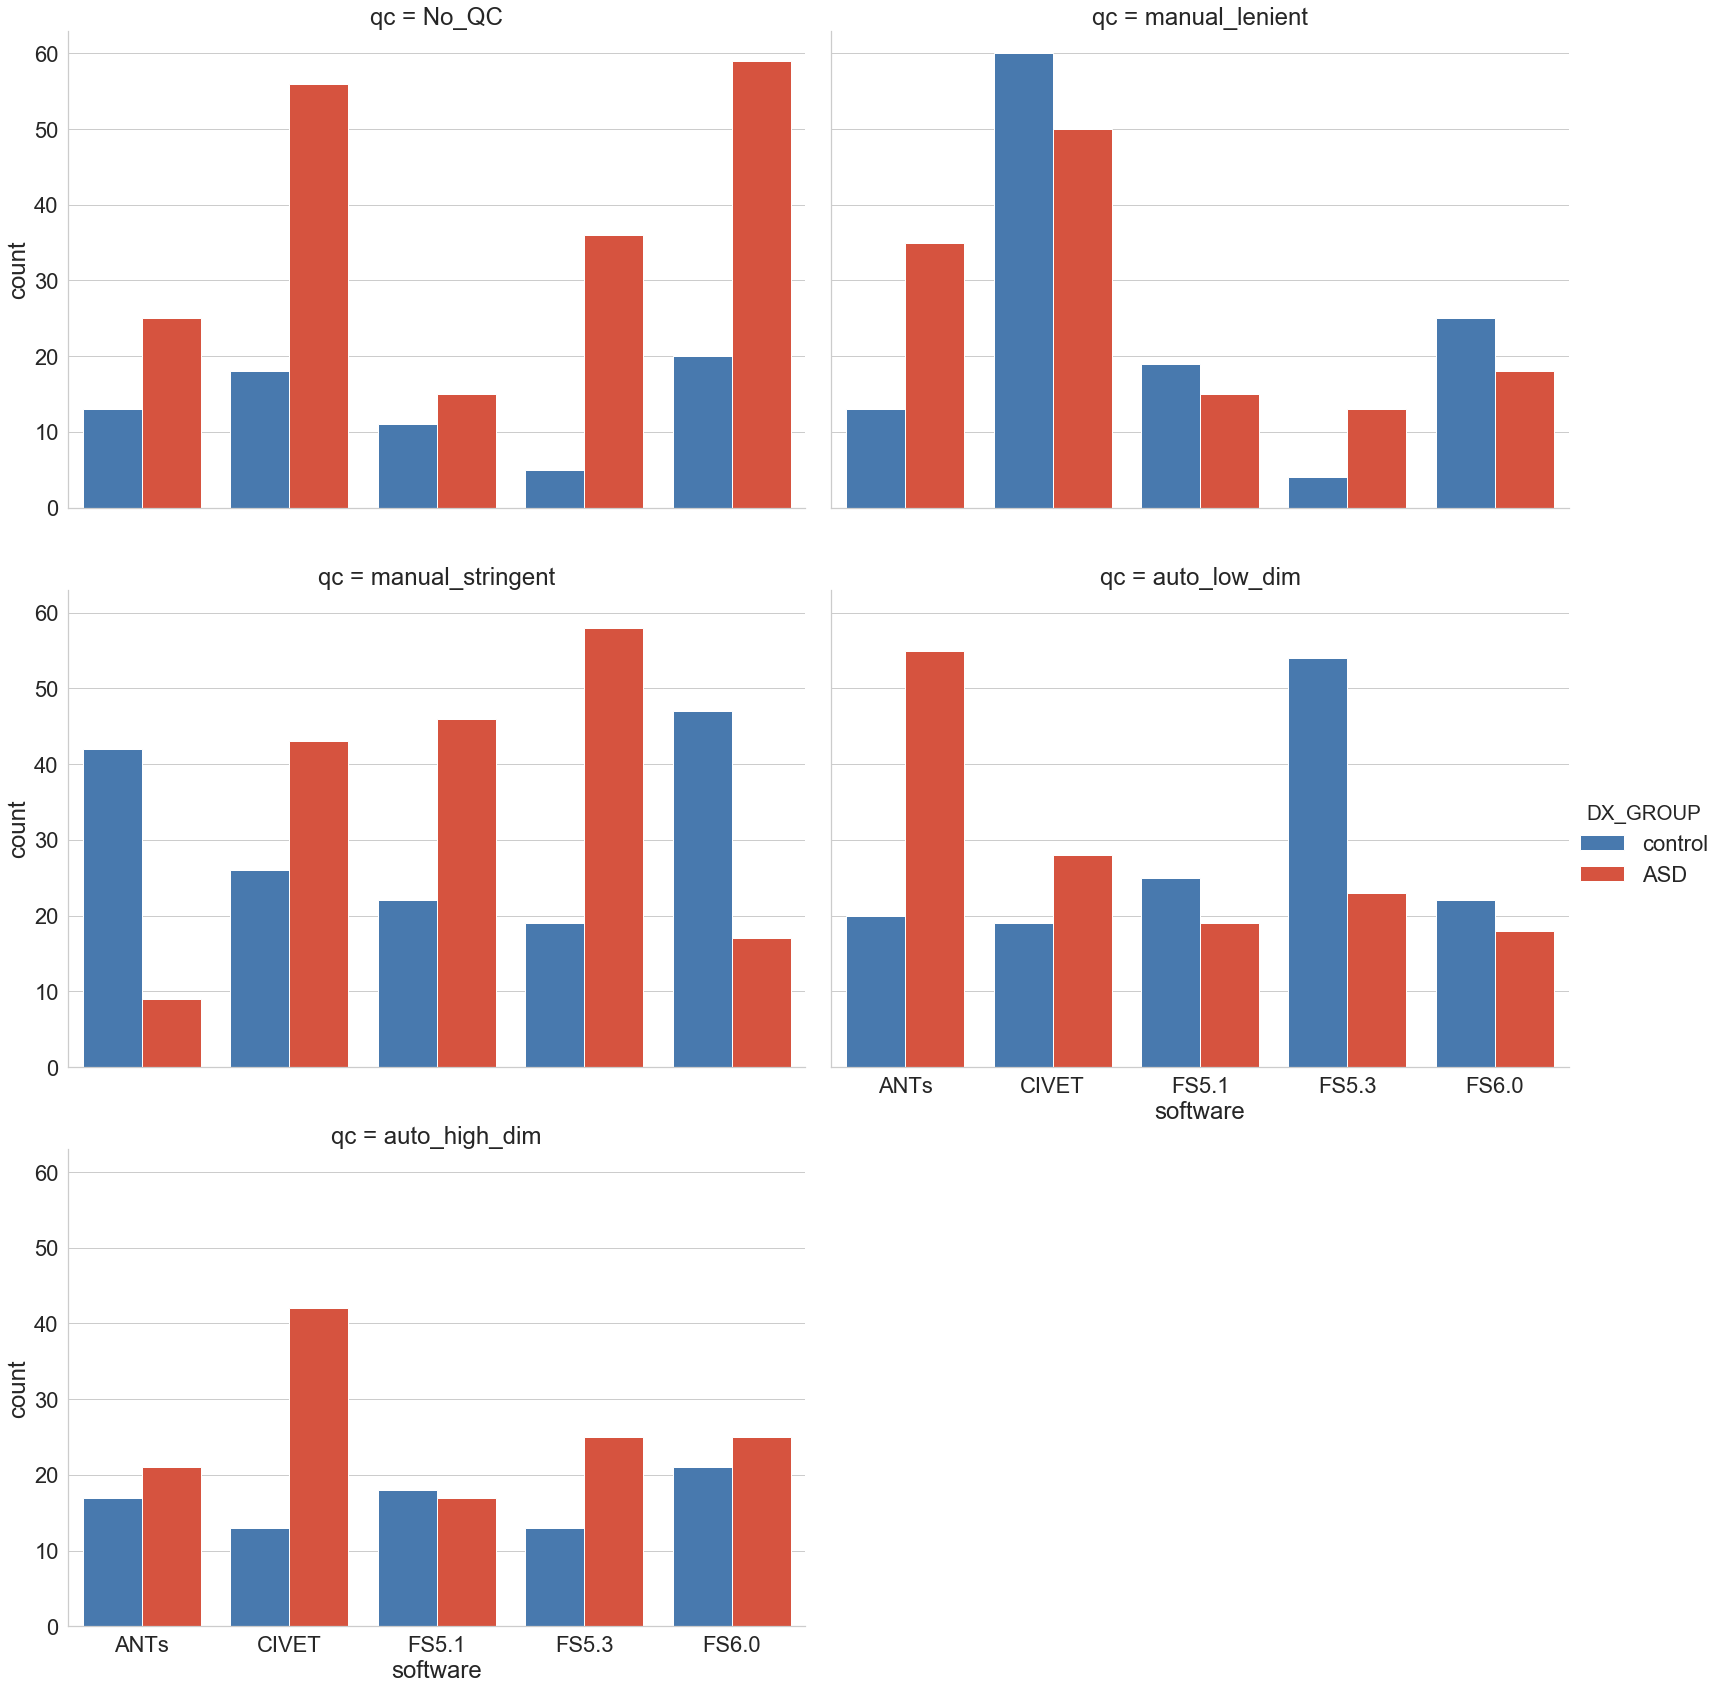

In [34]:
plot_df = feature_count_df
plot_df = plot_df #[plot_df['qc']=='No_QC']
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
sns.set(font_scale=2)

with sns.axes_style("whitegrid"): 
    x_order = ['ANTs','CIVET','FS5.1','FS5.3','FS6.0']
    g = sns.catplot(y='count',x=data_label,hue='DX_GROUP', col='qc', col_wrap=2,
                    kind='bar', palette=palette, height=8, aspect=1.4, data=plot_df, order=x_order)


### Compare statsmodels performance 
- statmodels performance plots are generate using "generate_plots" notebook

In [12]:
save_sm_perf = False
sm_results_dir = results_dir + 'sm2/atlas'

model_type = 'ols'
if model_type == 'ols':
    covar_cols = [('DX_GROUP','cat'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('roi','continuous')
    signific_col = ('AGE_AT_SCAN','continuous')
    stat_model = 'ols' 
elif model_type == 'logit':
    covar_cols = [('AGE_AT_SCAN','continuous'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('DX_GROUP','cat') 
    signific_col = ('roi','continuous') 
    stat_model = 'logit' 
else:
    print('unknown stat model')

roi_cols = common_roi_cols

for qc in qc_list:
    print('QC type {}'.format(qc))
    master_df = master_df_dict[qc]
    sm_perf = computeSoftwareStatsModels(master_df,data_label,roi_cols,covar_cols,outcome_col,signific_col,stat_model)
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    filtered_subs = master_df[subject_ID_col].unique()
    if save_sm_perf:
        save_path = '{}Software_DKT_sm_perf_{}_{}_{}_QC_{}_N_{}.pkl'.format(sm_results_dir,outcome_col[0],signific_col[0],
                                                                         stat_model,qc,len(filtered_subs))
        print('Saving sm_perf dictionary at \n{}'.format(save_path))
        sm_perf.to_pickle(save_path)


QC type No_QC
Running 62 mass-univariate ols statsmodels on 5 software
software ANTs
Example statsmodel run:
 L_parsorbitalis ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                      roi      coef      t_val         p_val    p_val_corr  \
47           L_precuneus -0.023962 -17.359359  4.462826e-57  2.766952e-55   
46           R_precuneus -0.021202 -15.693155  2.922874e-48  9.060909e-47   
31    L_inferiorparietal -0.023072 -14.220925  7.540301e-41  1.558329e-39   
27    R_isthmuscingulate -0.022793 -13.978348  1.147260e-39  1.778254e-38   
35    L_isthmuscingulate -0.022342 -13.685718  2.951937e-38  3.660402e-37   
36    R_inferiorparietal -0.023574 -13.559879  1.178163e-37  1.217435e-36   
14  L_posteriorcingulate -0.022629 -13.290321  2.226116e-36  1.971703e-35   
17         L_paracentral -0.015865 -13.117526  1.437094e-35  1.113748e-34   
16         R_paracentral -0.013759 -11.612746  8.328390e-29  5.737336e-28   
44  R_posteriorcingulate 

Example statsmodel run:
 L_parsorbitalis ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef      t_val         p_val    p_val_corr  \
46             R_precuneus -0.017548 -18.388548  2.657822e-62  1.647850e-60   
47             L_precuneus -0.017893 -18.008202  3.132594e-60  9.711040e-59   
36      R_inferiorparietal -0.017036 -16.798710  9.306111e-54  1.923263e-52   
31      L_inferiorparietal -0.017825 -16.591658  1.142378e-52  1.770686e-51   
38       L_superiorfrontal -0.017556 -16.079452  5.317309e-50  6.593463e-49   
43  L_lateralorbitofrontal -0.018287 -15.455525  8.353956e-47  8.632421e-46   
11  R_rostralmiddlefrontal -0.016803 -15.332909  3.489059e-46  3.090310e-45   
48      R_superiorparietal -0.014917 -15.208715  1.475619e-45  1.107873e-44   
32       R_superiorfrontal -0.017234 -15.201288  1.608203e-45  1.107873e-44   
26      L_superiorparietal -0.014538 -15.034897  1.099264e-44  6.815440e-44   

   softwar

Example statsmodel run:
 L_parsorbitalis ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                      roi      coef      t_val         p_val    p_val_corr  \
47           L_precuneus -0.032159 -15.116890  1.405947e-44  8.716871e-43   
46           R_precuneus -0.029692 -14.562331  6.962056e-42  2.158237e-40   
31    L_inferiorparietal -0.034884 -14.233373  2.613181e-40  5.400574e-39   
36    R_inferiorparietal -0.034583 -13.020231  1.132073e-34  1.754712e-33   
27    R_isthmuscingulate -0.031038 -12.509195  2.195883e-32  2.722895e-31   
35    L_isthmuscingulate -0.028275 -11.215764  7.493970e-27  7.743769e-26   
14  L_posteriorcingulate -0.026383 -10.209778  7.898066e-23  6.995430e-22   
17         L_paracentral -0.018375  -9.710723  6.218495e-21  4.819334e-20   
26    L_superiorparietal -0.016167  -9.269542  2.581204e-19  1.778163e-18   
60       R_supramarginal -0.019771  -8.681221  3.027929e-17  1.877316e-16   

   software  
47     ANTs  
46  

Example statsmodel run:
 L_parsorbitalis ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef      t_val         p_val    p_val_corr  \
47             L_precuneus -0.021788 -14.401933  5.932224e-41  3.171152e-39   
46             R_precuneus -0.020859 -14.352070  1.022952e-40  3.171152e-39   
31      L_inferiorparietal -0.021718 -13.941839  8.724012e-39  1.719838e-37   
2   L_rostralmiddlefrontal -0.023951 -13.914817  1.166487e-38  1.719838e-37   
36      R_inferiorparietal -0.021426 -13.898700  1.386966e-38  1.719838e-37   
11  R_rostralmiddlefrontal -0.022234 -13.851169  2.309599e-38  2.386586e-37   
54  R_lateralorbitofrontal -0.024823 -13.406870  2.593910e-36  2.022442e-35   
48      R_superiorparietal -0.019657 -13.406297  2.609603e-36  2.022442e-35   
43  L_lateralorbitofrontal -0.024017 -13.295903  8.324185e-36  5.734438e-35   
53               R_lingual -0.018633 -12.568433  1.515055e-32  9.393341e-32   

   softwar

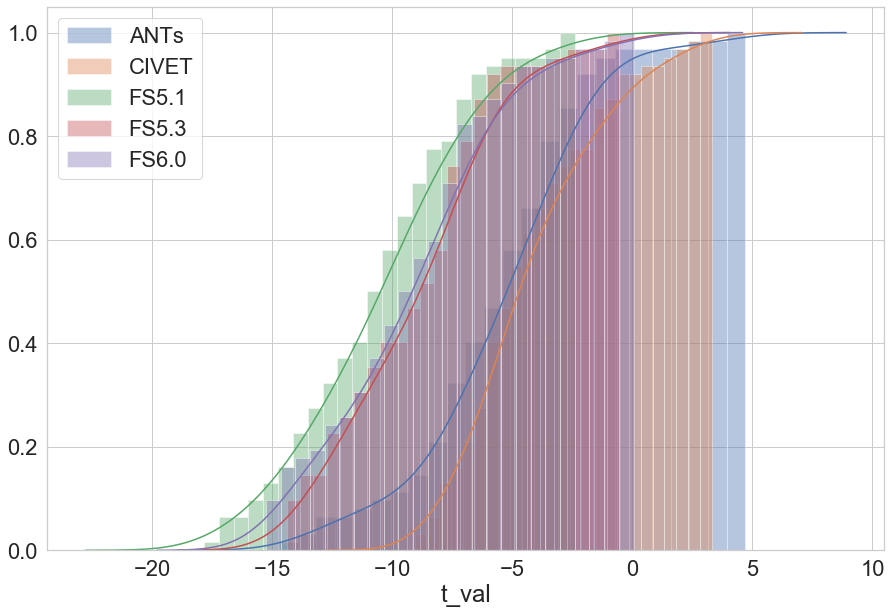

In [26]:
plot_df = sm_perf.copy()
plt.figure(figsize=(15,10))
with sns.axes_style("whitegrid"): 
    for software in plot_df['software'].unique():
        g = sns.distplot(plot_df[plot_df['software']==software]['t_val'],label=software, bins=25,
                         hist_kws= {'cumulative': True} ,kde_kws = {'cumulative': True})
    plt.legend()